In [1]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
matplotlib.use('Agg')
import datetime


%matplotlib inline
from RL_env.config import config
from RL_env.marketdata.yahoodownloader import YahooDownloader
from RL_env.preprocessing.preprocessors import FeatureEngineer
from RL_env.preprocessing.data import data_split
from RL_env.env.env_stocktrading import StockTradingEnv
from RL_env.model.models import DRLAgent,DRLEnsembleAgent
from RL_env.trade.backtest import backtest_stats, get_baseline, backtest_plot
from RL_env.trade.backtest import convert_daily_return_to_pyfolio_ts,get_daily_return


from pprint import pprint
from pyfolio import timeseries

import sys
sys.path.append("../FinRL-Library")

import itertools

In [2]:
import os
if not os.path.exists("./" + config.DATA_SAVE_DIR):
    os.makedirs("./" + config.DATA_SAVE_DIR)
if not os.path.exists("./" + config.TRAINED_MODEL_DIR):
    os.makedirs("./" + config.TRAINED_MODEL_DIR)
if not os.path.exists("./" + config.TENSORBOARD_LOG_DIR):
    os.makedirs("./" + config.TENSORBOARD_LOG_DIR)
if not os.path.exists("./" + config.RESULTS_DIR):
    os.makedirs("./" + config.RESULTS_DIR)

In [3]:
start_date=config.START_DATE
end_date=config.END_DATE

In [4]:
df = YahooDownloader(start_date = start_date,
                     end_date = end_date,
                     ticker_list = config.PRO1_20_TICKER).fetch_data()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

In [5]:
# df.to_csv('susa.csv')

In [6]:
df.head()

,date,open,high,low,close,volume,tic,day
0,2000-01-03,14.968750,15.593750,14.687500,15.500000,7843200,AMD,0
1,2000-01-03,30.500000,30.625000,29.000000,24.693115,433900,AMT,0
2,2000-01-03,25.666668,25.722221,24.000000,17.434628,19442925,BBY,0
3,2000-01-03,32.791668,32.833332,28.645832,31.083332,2792700,BIIB,0
4,2000-01-03,21.937500,21.937500,19.812500,10.138574,1468700,BKR,0


In [7]:
df.tail(10)

,date,open,high,low,close,volume,tic,day
105670,2020-12-31,215.250000,216.839996,214.729996,215.876328,752300,ECL,3
105671,2020-12-31,70.879997,72.320000,70.760002,70.778145,2081400,ED,3
105672,2020-12-31,85.480003,86.610001,84.989998,85.249344,1117000,ES,3
105673,2020-12-31,112.559998,113.959999,112.320000,113.860001,2052200,FISV,3
105674,2020-12-31,405.720001,408.850006,402.309998,405.225250,223500,GWW,3
105675,2020-12-31,93.750000,94.190002,92.800003,92.224770,559200,HAS,3
105676,2020-12-31,12.520000,12.680000,12.430000,12.512330,8675400,HBAN,3
105677,2020-12-31,61.529999,62.290001,61.330002,61.070087,1813100,K,3
105678,2020-12-31,54.450001,54.930000,54.270000,54.387314,8495000,KO,3
105679,2020-12-31,63.549999,64.739998,62.709999,63.518803,1424900,WELL,3


In [8]:
df.shape

(105680, 8)

In [9]:
fe = FeatureEngineer(
                    use_technical_indicator=True,
                    use_turbulence=False,
                    user_defined_feature = True)

df = fe.preprocess_data(df)

Successfully added technical indicators
Successfully added user defined features


In [10]:
df.head()

,date,open,high,low,close,volume,tic,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,daily_return,log_return,return_lag_4
0,2000-01-03,14.968750,15.593750,14.687500,15.500000,7843200,AMD,0,0.0,16.299937,13.825063,0.0,-66.666667,100.0,15.500000,15.500000,0.593104,0.465684,-0.116574
5284,2000-01-03,30.500000,30.625000,29.000000,24.693115,433900,AMT,0,0.0,16.299937,13.825063,0.0,-66.666667,100.0,24.693115,24.693115,0.593104,0.465684,-0.116574
10568,2000-01-03,25.666668,25.722221,24.000000,17.434628,19442925,BBY,0,0.0,16.299937,13.825063,0.0,-66.666667,100.0,17.434628,17.434628,-0.293948,-0.348066,-0.116574
15852,2000-01-03,32.791668,32.833332,28.645832,31.083332,2792700,BIIB,0,0.0,16.299937,13.825063,0.0,-66.666667,100.0,31.083332,31.083332,0.782850,0.578213,-0.116574
21136,2000-01-03,21.937500,21.937500,19.812500,10.138574,1468700,BKR,0,0.0,16.299937,13.825063,0.0,-66.666667,100.0,10.138574,10.138574,-0.673826,-1.120324,-0.116574


In [11]:
# add covariance matrix as states
df=df.sort_values(['date','tic'],ignore_index=True)
df.index = df.date.factorize()[0]

cov_list = []
# look back is one year
lookback=252
for i in range(lookback,len(df.index.unique())):
    data_lookback = df.loc[i-lookback:i,:]
    price_lookback=data_lookback.pivot_table(index = 'date',columns = 'tic', values = 'close')
    return_lookback = price_lookback.pct_change().dropna()
    covs = return_lookback.cov().values 
    cov_list.append(covs)

df_cov = pd.DataFrame({'date':df.date.unique()[lookback:],'cov_list':cov_list})
df = df.merge(df_cov, on='date')
df = df.sort_values(['date','tic']).reset_index(drop=True)

In [12]:
df.shape

(100640, 20)

In [13]:
df.head(10)

,date,open,high,low,close,volume,tic,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,daily_return,log_return,return_lag_4,cov_list
0,2001-01-02,14.125000,14.750000,14.125000,14.375000,4863600,AMD,1,-1.266954,17.488072,12.968178,39.175257,-76.161462,26.549249,16.345833,18.960417,2.056291,1.117202,1.185410,"[[0.0029471121413137836, 0.0004924540423471578..."
1,2001-01-02,37.875000,37.875000,36.187500,30.537334,1140900,AMT,1,0.232633,33.575454,26.619947,50.019169,75.514363,5.197387,29.245639,30.431155,1.124336,0.753459,2.727126,"[[0.0029471121413137836, 0.0004924540423471578..."
2,2001-01-02,13.166667,13.472222,12.361111,8.453153,3193875,BBY,1,-0.518848,9.269444,6.572671,42.124599,21.463034,1.628592,8.392145,11.011113,-0.723186,-1.284411,-0.404355,"[[0.0029471121413137836, 0.0004924540423471578..."
3,2001-01-02,63.083332,63.666668,58.020832,59.250000,5691300,BIIB,1,0.095880,75.095405,57.665012,48.264690,-50.384603,18.702324,63.631944,63.052951,6.009219,1.947226,2.422713,"[[0.0029471121413137836, 0.0004924540423471578..."
4,2001-01-02,42.375000,43.500000,41.812500,21.528893,2300900,BKR,1,0.883887,23.050113,15.559003,59.720235,126.886495,40.411668,19.034124,18.771179,-0.636643,-1.012370,3.577292,"[[0.0029471121413137836, 0.0004924540423471578..."
5,2001-01-02,23.625000,23.625000,22.812500,13.508592,3285000,CAT,1,0.671005,14.218267,11.318619,65.091311,126.899833,44.190251,12.283519,11.049746,-0.372537,-0.466070,-0.060272,"[[0.0029471121413137836, 0.0004924540423471578..."
6,2001-01-02,43.187500,43.187500,40.812500,26.614565,1676500,CB,1,0.415880,28.645922,23.808830,54.411886,81.691394,11.865872,25.865298,25.120649,0.970195,0.678133,-0.128458,"[[0.0029471121413137836, 0.0004924540423471578..."
7,2001-01-02,12.959629,13.018859,12.568707,11.866300,4349007,DHR,1,0.176540,12.556106,10.996818,56.946840,69.055754,16.454761,11.671042,10.986982,-0.554143,-0.807756,0.403772,"[[0.0029471121413137836, 0.0004924540423471578..."
8,2001-01-02,28.053595,28.053595,27.252064,21.765089,6545261,DIS,1,-0.722133,24.839156,20.504373,41.112977,-86.370268,23.723154,22.743832,25.299904,0.834193,0.606605,-0.632657,"[[0.0029471121413137836, 0.0004924540423471578..."
9,2001-01-02,21.843750,21.906250,18.531250,19.395668,2344400,EA,1,-0.073481,22.700748,16.909376,46.734297,-8.001071,19.520729,20.018321,22.083456,-0.108863,-0.115258,-0.099087,"[[0.0029471121413137836, 0.0004924540423471578..."


In [14]:
train = data_split(df, config.START_DATE,'2019-01-01')
trade = data_split(df, '2019-01-02', config.END_DATE)

In [15]:
train.head(10)

,date,open,high,low,close,volume,tic,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,daily_return,log_return,return_lag_4,cov_list
0,2001-01-02,14.125000,14.750000,14.125000,14.375000,4863600,AMD,1,-1.266954,17.488072,12.968178,39.175257,-76.161462,26.549249,16.345833,18.960417,2.056291,1.117202,1.185410,"[[0.0029471121413137836, 0.0004924540423471578..."
0,2001-01-02,37.875000,37.875000,36.187500,30.537334,1140900,AMT,1,0.232633,33.575454,26.619947,50.019169,75.514363,5.197387,29.245639,30.431155,1.124336,0.753459,2.727126,"[[0.0029471121413137836, 0.0004924540423471578..."
0,2001-01-02,13.166667,13.472222,12.361111,8.453153,3193875,BBY,1,-0.518848,9.269444,6.572671,42.124599,21.463034,1.628592,8.392145,11.011113,-0.723186,-1.284411,-0.404355,"[[0.0029471121413137836, 0.0004924540423471578..."
0,2001-01-02,63.083332,63.666668,58.020832,59.250000,5691300,BIIB,1,0.095880,75.095405,57.665012,48.264690,-50.384603,18.702324,63.631944,63.052951,6.009219,1.947226,2.422713,"[[0.0029471121413137836, 0.0004924540423471578..."
0,2001-01-02,42.375000,43.500000,41.812500,21.528893,2300900,BKR,1,0.883887,23.050113,15.559003,59.720235,126.886495,40.411668,19.034124,18.771179,-0.636643,-1.012370,3.577292,"[[0.0029471121413137836, 0.0004924540423471578..."
0,2001-01-02,23.625000,23.625000,22.812500,13.508592,3285000,CAT,1,0.671005,14.218267,11.318619,65.091311,126.899833,44.190251,12.283519,11.049746,-0.372537,-0.466070,-0.060272,"[[0.0029471121413137836, 0.0004924540423471578..."
0,2001-01-02,43.187500,43.187500,40.812500,26.614565,1676500,CB,1,0.415880,28.645922,23.808830,54.411886,81.691394,11.865872,25.865298,25.120649,0.970195,0.678133,-0.128458,"[[0.0029471121413137836, 0.0004924540423471578..."
0,2001-01-02,12.959629,13.018859,12.568707,11.866300,4349007,DHR,1,0.176540,12.556106,10.996818,56.946840,69.055754,16.454761,11.671042,10.986982,-0.554143,-0.807756,0.403772,"[[0.0029471121413137836, 0.0004924540423471578..."
0,2001-01-02,28.053595,28.053595,27.252064,21.765089,6545261,DIS,1,-0.722133,24.839156,20.504373,41.112977,-86.370268,23.723154,22.743832,25.299904,0.834193,0.606605,-0.632657,"[[0.0029471121413137836, 0.0004924540423471578..."
0,2001-01-02,21.843750,21.906250,18.531250,19.395668,2344400,EA,1,-0.073481,22.700748,16.909376,46.734297,-8.001071,19.520729,20.018321,22.083456,-0.108863,-0.115258,-0.099087,"[[0.0029471121413137836, 0.0004924540423471578..."


In [16]:
train.tail(10)

,date,open,high,low,close,volume,tic,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,daily_return,log_return,return_lag_4,cov_list
4526,2018-12-31,144.869995,147.580002,144.479996,144.223236,1199400,ECL,0,-2.850954,159.246404,135.470733,45.983474,-85.856629,24.410735,149.167172,148.891651,0.834579,0.606815,0.214182,"[[0.0015761865192430796, 2.23656007177958e-06,..."
4526,2018-12-31,76.480003,76.870003,75.680000,69.582092,1670200,ED,0,-0.587233,78.062459,68.169139,45.696873,-95.507832,19.496323,72.371382,70.967562,-0.517539,-0.728855,-0.433855,"[[0.0015761865192430796, 2.23656007177958e-06,..."
4526,2018-12-31,64.650002,65.050003,63.990002,60.687496,1492100,ES,0,-0.349099,66.446966,59.165841,49.590160,-131.029495,26.365842,62.566600,60.597499,-0.127829,-0.136770,-0.405625,"[[0.0015761865192430796, 2.23656007177958e-06,..."
4526,2018-12-31,73.379997,73.620003,72.620003,73.489998,1538300,FISV,0,-1.470788,80.392245,69.128754,45.171673,-74.724872,20.279496,75.865666,77.085500,0.210958,0.191412,-0.321586,"[[0.0015761865192430796, 2.23656007177958e-06,..."
4526,2018-12-31,281.700012,284.850006,279.339996,269.825195,460400,GWW,0,-5.310091,298.136886,249.873200,43.640605,-63.371723,6.560356,279.967395,280.883427,2.671591,1.300625,2.432289,"[[0.0015761865192430796, 2.23656007177958e-06,..."
4526,2018-12-31,81.290001,81.629997,80.139999,75.489403,1147100,HAS,0,-3.177538,84.202282,70.740066,36.711152,-73.177051,35.175293,81.403747,85.669721,-0.720228,-1.273782,-0.476579,"[[0.0015761865192430796, 2.23656007177958e-06,..."
4526,2018-12-31,11.910000,12.080000,11.720000,10.678969,12627900,HBAN,0,-0.546089,12.800301,9.452751,34.756977,-73.678320,42.675185,11.740203,12.257795,-0.858537,-1.955716,-0.846527,"[[0.0015761865192430796, 2.23656007177958e-06,..."
4526,2018-12-31,57.189999,57.450001,56.549999,51.962708,2093000,K,0,-1.527906,58.288490,50.203382,35.282657,-126.123636,42.598716,54.860657,58.005941,3.865892,1.582250,-0.143766,"[[0.0015761865192430796, 2.23656007177958e-06,..."
4526,2018-12-31,47.490002,47.540001,46.959999,44.010803,10576300,KO,0,-0.375783,47.241390,42.879904,48.477990,-120.160430,13.005381,45.252424,44.338623,-0.153031,-0.166091,-0.401132,"[[0.0015761865192430796, 2.23656007177958e-06,..."
4526,2018-12-31,69.599998,69.599998,68.089996,62.340950,1421800,WELL,0,-0.162645,67.513984,60.594380,51.596076,-97.563394,17.867962,63.754347,61.038805,0.416492,0.348183,-0.768958,"[[0.0015761865192430796, 2.23656007177958e-06,..."


In [17]:
trade.head(10)

,date,open,high,low,close,volume,tic,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,daily_return,log_return,return_lag_4,cov_list
0,2019-01-02,18.010000,19.000000,17.980000,18.830000,87148700,AMD,2,-0.800179,22.588778,15.842221,46.067794,-52.118450,6.093693,19.553333,21.073667,-0.697951,-1.197167,-0.750561,"[[0.001574050703799498, 1.3245453056820954e-06..."
0,2019-01-02,157.110001,157.110001,153.929993,150.357346,2030600,AMT,2,-0.642107,162.166736,147.382685,49.761298,-150.400643,30.599100,154.841746,149.998857,6.984989,2.077563,13.079762,"[[0.001574050703799498, 1.3245453056820954e-06..."
0,2019-01-02,52.189999,54.040001,52.000000,50.438507,3335700,BBY,2,-3.177570,61.170126,42.470401,38.505531,-63.715950,34.760982,54.474928,60.294387,-0.664542,-1.092260,-0.029333,"[[0.001574050703799498, 1.3245453056820954e-06..."
0,2019-01-02,296.839996,307.130005,296.540009,304.690002,1336500,BIIB,2,-6.883490,338.548087,275.007919,46.228711,-50.056617,2.547273,312.327334,316.939999,5.040821,1.798540,5.923073,"[[0.001574050703799498, 1.3245453056820954e-06..."
0,2019-01-02,21.190001,21.629999,20.840000,19.261240,7150000,BKR,2,-0.653913,20.685509,18.584547,35.350363,-72.143310,26.509029,20.034131,22.782450,-0.936784,-2.761200,-0.691034,"[[0.001574050703799498, 1.3245453056820954e-06..."
0,2019-01-02,124.029999,127.879997,123.000000,118.137177,4783200,CAT,2,-0.680049,125.145761,109.015061,48.229091,-5.147002,0.873482,117.640500,119.834356,5.133415,1.813752,5.273881,"[[0.001574050703799498, 1.3245453056820954e-06..."
0,2019-01-02,127.650002,128.610001,126.070000,121.106941,1391900,CB,2,-0.731880,126.772174,115.870002,48.046324,-52.250612,8.981361,122.925298,122.024655,0.025138,0.024828,-0.194539,"[[0.001574050703799498, 1.3245453056820954e-06..."
0,2019-01-02,101.660004,102.169998,99.970001,99.508934,2397100,DHR,2,-0.583067,106.112952,94.625991,48.061772,-46.733743,7.317695,101.299826,100.819349,-0.178338,-0.196427,0.972876,"[[0.001574050703799498, 1.3245453056820954e-06..."
0,2019-01-02,108.099998,109.139999,107.730003,107.654343,9723500,DIS,2,-1.651913,115.412761,101.243481,47.045442,-60.257986,13.997384,109.576867,111.420507,0.081856,0.078678,-0.646676,"[[0.001574050703799498, 1.3245453056820954e-06..."
0,2019-01-02,77.220001,80.639999,77.199997,80.068306,3176600,EA,2,-2.422293,85.141135,74.754382,39.023145,-62.467787,40.456014,81.361098,89.570499,-0.256246,-0.296045,3.156965,"[[0.001574050703799498, 1.3245453056820954e-06..."


In [18]:
trade.tail(10)

,date,open,high,low,close,volume,tic,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,daily_return,log_return,return_lag_4,cov_list
504,2020-12-31,215.250000,216.839996,214.729996,215.876328,752300,ECL,3,0.419317,226.131927,210.861967,53.059164,-47.571303,4.629603,217.759670,208.843539,0.506974,0.410103,0.197703,"[[0.0014696193133957034, 0.0005258240164683782..."
504,2020-12-31,70.879997,72.320000,70.760002,70.778145,2081400,ED,3,-1.557552,74.545328,67.140253,43.923371,-61.840806,12.272347,72.520429,75.583521,-0.672136,-1.115155,-0.538086,"[[0.0014696193133957034, 0.0005258240164683782..."
504,2020-12-31,85.480003,86.610001,84.989998,85.249344,1117000,ES,3,-0.714873,85.641019,81.931628,49.642333,-9.867831,2.876117,84.637144,87.291765,0.204459,0.186030,-0.615868,"[[0.0014696193133957034, 0.0005258240164683782..."
504,2020-12-31,112.559998,113.959999,112.320000,113.860001,2052200,FISV,3,0.472372,118.118568,110.069430,55.923152,-23.287932,12.287593,113.997333,108.126499,0.335611,0.289389,-0.371564,"[[0.0014696193133957034, 0.0005258240164683782..."
504,2020-12-31,405.720001,408.850006,402.309998,405.225250,223500,GWW,3,2.559056,412.639763,396.562352,56.019007,-57.919989,7.223765,407.028398,391.450851,2.558978,1.269473,1.828767,"[[0.0014696193133957034, 0.0005258240164683782..."
504,2020-12-31,93.750000,94.190002,92.800003,92.224770,559200,HAS,3,1.068369,94.573902,86.813304,57.363351,64.261552,21.869661,90.999573,87.834681,-0.772411,-1.480214,-0.572789,"[[0.0014696193133957034, 0.0005258240164683782..."
504,2020-12-31,12.520000,12.680000,12.430000,12.512330,8675400,HBAN,3,0.172122,12.900465,11.949892,58.131490,29.038220,7.238909,12.304420,11.274344,-0.864328,-1.997514,-0.823218,"[[0.0014696193133957034, 0.0005258240164683782..."
504,2020-12-31,61.529999,62.290001,61.330002,61.070087,1813100,K,3,-0.366267,61.737198,59.920148,46.907832,-52.006599,14.897189,61.305163,62.411819,3.880793,1.585308,-0.283630,"[[0.0014696193133957034, 0.0005258240164683782..."
504,2020-12-31,54.450001,54.930000,54.270000,54.387314,8495000,KO,3,0.590886,54.180601,51.873666,60.793425,204.696472,19.888558,52.634631,51.200636,-0.109428,-0.115891,-0.522332,"[[0.0014696193133957034, 0.0005258240164683782..."
504,2020-12-31,63.549999,64.739998,62.709999,63.518803,1424900,WELL,3,0.267170,65.430426,60.653705,54.673178,-13.278359,2.182991,63.045014,59.666386,0.167897,0.155205,-0.843251,"[[0.0014696193133957034, 0.0005258240164683782..."


In [19]:
from RL_env.env.env_portfolio import StockPortfolioEnv

In [20]:
stock_dimension = len(train.tic.unique())
state_space = stock_dimension
print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")

Stock Dimension: 20, State Space: 20


In [21]:
train.tic.unique()

array(['AMD', 'AMT', 'BBY', 'BIIB', 'BKR', 'CAT', 'CB', 'DHR', 'DIS',
       'EA', 'ECL', 'ED', 'ES', 'FISV', 'GWW', 'HAS', 'HBAN', 'K', 'KO',
       'WELL'], dtype=object)

In [22]:
env_kwargs = {
    "hmax": 100, 
    "initial_amount": 100000, 
    "transaction_cost_pct": 0.0025, 
    "state_space": state_space, 
    "stock_dim": stock_dimension, 
    "tech_indicator_list": config.TECHNICAL_INDICATORS_LIST, 
    "action_space": stock_dimension, 
    "reward_scaling": 1e-4,
    "turbulence_threshold":330
}

e_train_gym = StockPortfolioEnv(df = train, **env_kwargs)


In [23]:
env_train, _ = e_train_gym.get_sb_env()
print(type(env_train))

<class 'stable_baselines3.common.vec_env.dummy_vec_env.DummyVecEnv'>


In [24]:
# initialize
agent = DRLAgent(env = env_train)

In [25]:
agent = DRLAgent(env = env_train)
A2C_PARAMS = {"n_steps": 5, "ent_coef": 0.005, "learning_rate": 0.0002}
model_a2c = agent.get_model(model_name="a2c",model_kwargs = A2C_PARAMS)

{'n_steps': 5, 'ent_coef': 0.005, 'learning_rate': 0.0002}
Using cpu device


In [26]:
trained_a2c = agent.train_model(model=model_a2c, 
                                tb_log_name='a2c',
                                total_timesteps=500000)

Logging to tensorboard_log/a2c\a2c_15
------------------------------------
| time/                 |          |
|    fps                | 85       |
|    iterations         | 100      |
|    time_elapsed       | 5        |
|    total_timesteps    | 500      |
| train/                |          |
|    entropy_loss       | -28.4    |
|    explained_variance | 1.19e-07 |
|    learning_rate      | 0.0002   |
|    n_updates          | 99       |
|    policy_loss        | 8.04e+06 |
|    std                | 1        |
|    value_loss         | 1.18e+11 |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 128      |
|    iterations         | 200      |
|    time_elapsed       | 7        |
|    total_timesteps    | 1000     |
| train/                |          |
|    entropy_loss       | -28.3    |
|    explained_variance | 4.77e-07 |
|    learning_rate      | 0.0002   |
|    n_updates          | 199      |


------------------------------------
| time/                 |          |
|    fps                | 224      |
|    iterations         | 1500     |
|    time_elapsed       | 33       |
|    total_timesteps    | 7500     |
| train/                |          |
|    entropy_loss       | -28.2    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 1499     |
|    policy_loss        | 2.86e+07 |
|    std                | 0.992    |
|    value_loss         | 1.4e+12  |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 227      |
|    iterations         | 1600     |
|    time_elapsed       | 35       |
|    total_timesteps    | 8000     |
| train/                |          |
|    entropy_loss       | -28.2    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 1599     |
|    policy_loss        | 4.18e+07 |
|

------------------------------------
| time/                 |          |
|    fps                | 247      |
|    iterations         | 2900     |
|    time_elapsed       | 58       |
|    total_timesteps    | 14500    |
| train/                |          |
|    entropy_loss       | -28.1    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 2899     |
|    policy_loss        | 1.45e+07 |
|    std                | 0.986    |
|    value_loss         | 2.68e+11 |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 248      |
|    iterations         | 3000     |
|    time_elapsed       | 60       |
|    total_timesteps    | 15000    |
| train/                |          |
|    entropy_loss       | -28.1    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 2999     |
|    policy_loss        | 2.17e+07 |
|

------------------------------------
| time/                 |          |
|    fps                | 258      |
|    iterations         | 4300     |
|    time_elapsed       | 83       |
|    total_timesteps    | 21500    |
| train/                |          |
|    entropy_loss       | -28      |
|    explained_variance | 1.19e-07 |
|    learning_rate      | 0.0002   |
|    n_updates          | 4299     |
|    policy_loss        | 5.98e+07 |
|    std                | 0.983    |
|    value_loss         | 4.94e+12 |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 258      |
|    iterations         | 4400     |
|    time_elapsed       | 85       |
|    total_timesteps    | 22000    |
| train/                |          |
|    entropy_loss       | -28      |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 4399     |
|    policy_loss        | 7e+07    |
|

------------------------------------
| time/                 |          |
|    fps                | 262      |
|    iterations         | 5600     |
|    time_elapsed       | 106      |
|    total_timesteps    | 28000    |
| train/                |          |
|    entropy_loss       | -27.9    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 5599     |
|    policy_loss        | 1.29e+07 |
|    std                | 0.978    |
|    value_loss         | 2.71e+11 |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 263      |
|    iterations         | 5700     |
|    time_elapsed       | 108      |
|    total_timesteps    | 28500    |
| train/                |          |
|    entropy_loss       | -27.9    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 5699     |
|    policy_loss        | 1.65e+07 |
|

-------------------------------------
| time/                 |           |
|    fps                | 266       |
|    iterations         | 7000      |
|    time_elapsed       | 131       |
|    total_timesteps    | 35000     |
| train/                |           |
|    entropy_loss       | -27.8     |
|    explained_variance | -1.19e-07 |
|    learning_rate      | 0.0002    |
|    n_updates          | 6999      |
|    policy_loss        | 4.17e+07  |
|    std                | 0.971     |
|    value_loss         | 2.94e+12  |
-------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 266      |
|    iterations         | 7100     |
|    time_elapsed       | 133      |
|    total_timesteps    | 35500    |
| train/                |          |
|    entropy_loss       | -27.8    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 7099     |
|    policy_loss       

------------------------------------
| time/                 |          |
|    fps                | 266      |
|    iterations         | 8300     |
|    time_elapsed       | 155      |
|    total_timesteps    | 41500    |
| train/                |          |
|    entropy_loss       | -27.7    |
|    explained_variance | 1.79e-07 |
|    learning_rate      | 0.0002   |
|    n_updates          | 8299     |
|    policy_loss        | 1.34e+07 |
|    std                | 0.966    |
|    value_loss         | 2.85e+11 |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 267      |
|    iterations         | 8400     |
|    time_elapsed       | 157      |
|    total_timesteps    | 42000    |
| train/                |          |
|    entropy_loss       | -27.7    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 8399     |
|    policy_loss        | 1.84e+07 |
|

------------------------------------
| time/                 |          |
|    fps                | 267      |
|    iterations         | 9700     |
|    time_elapsed       | 181      |
|    total_timesteps    | 48500    |
| train/                |          |
|    entropy_loss       | -27.6    |
|    explained_variance | 1.19e-07 |
|    learning_rate      | 0.0002   |
|    n_updates          | 9699     |
|    policy_loss        | 4.32e+07 |
|    std                | 0.962    |
|    value_loss         | 3.03e+12 |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 267      |
|    iterations         | 9800     |
|    time_elapsed       | 182      |
|    total_timesteps    | 49000    |
| train/                |          |
|    entropy_loss       | -27.6    |
|    explained_variance | 5.96e-08 |
|    learning_rate      | 0.0002   |
|    n_updates          | 9799     |
|    policy_loss        | 5.66e+07 |
|

------------------------------------
| time/                 |          |
|    fps                | 269      |
|    iterations         | 11000    |
|    time_elapsed       | 204      |
|    total_timesteps    | 55000    |
| train/                |          |
|    entropy_loss       | -27.5    |
|    explained_variance | 2.98e-07 |
|    learning_rate      | 0.0002   |
|    n_updates          | 10999    |
|    policy_loss        | 1.19e+07 |
|    std                | 0.957    |
|    value_loss         | 2.37e+11 |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 269      |
|    iterations         | 11100    |
|    time_elapsed       | 205      |
|    total_timesteps    | 55500    |
| train/                |          |
|    entropy_loss       | -27.5    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 11099    |
|    policy_loss        | 1.73e+07 |
|

------------------------------------
| time/                 |          |
|    fps                | 270      |
|    iterations         | 12400    |
|    time_elapsed       | 229      |
|    total_timesteps    | 62000    |
| train/                |          |
|    entropy_loss       | -27.3    |
|    explained_variance | 1.19e-07 |
|    learning_rate      | 0.0002   |
|    n_updates          | 12399    |
|    policy_loss        | 4.19e+07 |
|    std                | 0.949    |
|    value_loss         | 2.67e+12 |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 270      |
|    iterations         | 12500    |
|    time_elapsed       | 231      |
|    total_timesteps    | 62500    |
| train/                |          |
|    entropy_loss       | -27.3    |
|    explained_variance | 5.96e-08 |
|    learning_rate      | 0.0002   |
|    n_updates          | 12499    |
|    policy_loss        | 5.22e+07 |
|

------------------------------------
| time/                 |          |
|    fps                | 270      |
|    iterations         | 13700    |
|    time_elapsed       | 253      |
|    total_timesteps    | 68500    |
| train/                |          |
|    entropy_loss       | -27.3    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 13699    |
|    policy_loss        | 8.64e+06 |
|    std                | 0.946    |
|    value_loss         | 1.34e+11 |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 270      |
|    iterations         | 13800    |
|    time_elapsed       | 254      |
|    total_timesteps    | 69000    |
| train/                |          |
|    entropy_loss       | -27.2    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 13799    |
|    policy_loss        | 1.43e+07 |
|

------------------------------------
| time/                 |          |
|    fps                | 270      |
|    iterations         | 15100    |
|    time_elapsed       | 279      |
|    total_timesteps    | 75500    |
| train/                |          |
|    entropy_loss       | -27.2    |
|    explained_variance | 1.79e-07 |
|    learning_rate      | 0.0002   |
|    n_updates          | 15099    |
|    policy_loss        | 4.02e+07 |
|    std                | 0.942    |
|    value_loss         | 2.26e+12 |
------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 270       |
|    iterations         | 15200     |
|    time_elapsed       | 280       |
|    total_timesteps    | 76000     |
| train/                |           |
|    entropy_loss       | -27.2     |
|    explained_variance | -1.19e-07 |
|    learning_rate      | 0.0002    |
|    n_updates          | 15199     |
|    policy_loss        | 5

------------------------------------
| time/                 |          |
|    fps                | 271      |
|    iterations         | 16400    |
|    time_elapsed       | 302      |
|    total_timesteps    | 82000    |
| train/                |          |
|    entropy_loss       | -27.1    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 16399    |
|    policy_loss        | 9.64e+06 |
|    std                | 0.937    |
|    value_loss         | 1.37e+11 |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 271      |
|    iterations         | 16500    |
|    time_elapsed       | 304      |
|    total_timesteps    | 82500    |
| train/                |          |
|    entropy_loss       | -27.1    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 16499    |
|    policy_loss        | 1.51e+07 |
|

------------------------------------
| time/                 |          |
|    fps                | 271      |
|    iterations         | 17800    |
|    time_elapsed       | 328      |
|    total_timesteps    | 89000    |
| train/                |          |
|    entropy_loss       | -26.9    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 17799    |
|    policy_loss        | 3.13e+07 |
|    std                | 0.93     |
|    value_loss         | 1.72e+12 |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 271      |
|    iterations         | 17900    |
|    time_elapsed       | 330      |
|    total_timesteps    | 89500    |
| train/                |          |
|    entropy_loss       | -26.9    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 17899    |
|    policy_loss        | 5.56e+07 |
|

------------------------------------
| time/                 |          |
|    fps                | 271      |
|    iterations         | 19200    |
|    time_elapsed       | 353      |
|    total_timesteps    | 96000    |
| train/                |          |
|    entropy_loss       | -26.8    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 19199    |
|    policy_loss        | 1.17e+07 |
|    std                | 0.923    |
|    value_loss         | 2.6e+11  |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 271      |
|    iterations         | 19300    |
|    time_elapsed       | 355      |
|    total_timesteps    | 96500    |
| train/                |          |
|    entropy_loss       | -26.7    |
|    explained_variance | 1.19e-07 |
|    learning_rate      | 0.0002   |
|    n_updates          | 19299    |
|    policy_loss        | 1.72e+07 |
|

-------------------------------------
| time/                 |           |
|    fps                | 0         |
|    iterations         | 20600     |
|    time_elapsed       | 209118    |
|    total_timesteps    | 103000    |
| train/                |           |
|    entropy_loss       | -26.7     |
|    explained_variance | -1.19e-07 |
|    learning_rate      | 0.0002    |
|    n_updates          | 20599     |
|    policy_loss        | 4.35e+07  |
|    std                | 0.918     |
|    value_loss         | 3.31e+12  |
-------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 0        |
|    iterations         | 20700    |
|    time_elapsed       | 209120   |
|    total_timesteps    | 103500   |
| train/                |          |
|    entropy_loss       | -26.7    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 20699    |
|    policy_loss       

------------------------------------
| time/                 |          |
|    fps                | 0        |
|    iterations         | 21900    |
|    time_elapsed       | 209151   |
|    total_timesteps    | 109500   |
| train/                |          |
|    entropy_loss       | -26.6    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 21899    |
|    policy_loss        | 1.46e+07 |
|    std                | 0.914    |
|    value_loss         | 3.13e+11 |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 0        |
|    iterations         | 22000    |
|    time_elapsed       | 209153   |
|    total_timesteps    | 110000   |
| train/                |          |
|    entropy_loss       | -26.6    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 21999    |
|    policy_loss        | 1.9e+07  |
|

------------------------------------
| time/                 |          |
|    fps                | 0        |
|    iterations         | 23300    |
|    time_elapsed       | 209181   |
|    total_timesteps    | 116500   |
| train/                |          |
|    entropy_loss       | -26.5    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 23299    |
|    policy_loss        | 4.77e+07 |
|    std                | 0.911    |
|    value_loss         | 3.51e+12 |
------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 0         |
|    iterations         | 23400     |
|    time_elapsed       | 209183    |
|    total_timesteps    | 117000    |
| train/                |           |
|    entropy_loss       | -26.5     |
|    explained_variance | -1.19e-07 |
|    learning_rate      | 0.0002    |
|    n_updates          | 23399     |
|    policy_loss        | 5

-------------------------------------
| time/                 |           |
|    fps                | 0         |
|    iterations         | 24600     |
|    time_elapsed       | 209208    |
|    total_timesteps    | 123000    |
| train/                |           |
|    entropy_loss       | -26.4     |
|    explained_variance | -2.38e-07 |
|    learning_rate      | 0.0002    |
|    n_updates          | 24599     |
|    policy_loss        | 1.08e+07  |
|    std                | 0.905     |
|    value_loss         | 2.28e+11  |
-------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 0        |
|    iterations         | 24700    |
|    time_elapsed       | 209210   |
|    total_timesteps    | 123500   |
| train/                |          |
|    entropy_loss       | -26.4    |
|    explained_variance | 1.79e-07 |
|    learning_rate      | 0.0002   |
|    n_updates          | 24699    |
|    policy_loss       

------------------------------------
| time/                 |          |
|    fps                | 0        |
|    iterations         | 26000    |
|    time_elapsed       | 209237   |
|    total_timesteps    | 130000   |
| train/                |          |
|    entropy_loss       | -26.3    |
|    explained_variance | 1.79e-07 |
|    learning_rate      | 0.0002   |
|    n_updates          | 25999    |
|    policy_loss        | 4.52e+07 |
|    std                | 0.9      |
|    value_loss         | 3.52e+12 |
------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 0         |
|    iterations         | 26100     |
|    time_elapsed       | 209240    |
|    total_timesteps    | 130500    |
| train/                |           |
|    entropy_loss       | -26.3     |
|    explained_variance | -2.38e-07 |
|    learning_rate      | 0.0002    |
|    n_updates          | 26099     |
|    policy_loss        | 5

-------------------------------------
| time/                 |           |
|    fps                | 0         |
|    iterations         | 27300     |
|    time_elapsed       | 209268    |
|    total_timesteps    | 136500    |
| train/                |           |
|    entropy_loss       | -26.2     |
|    explained_variance | -1.19e-07 |
|    learning_rate      | 0.0002    |
|    n_updates          | 27299     |
|    policy_loss        | 1.1e+07   |
|    std                | 0.897     |
|    value_loss         | 1.82e+11  |
-------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 0         |
|    iterations         | 27400     |
|    time_elapsed       | 209269    |
|    total_timesteps    | 137000    |
| train/                |           |
|    entropy_loss       | -26.2     |
|    explained_variance | -1.19e-07 |
|    learning_rate      | 0.0002    |
|    n_updates          | 27399     |
|    policy_

-------------------------------------
| time/                 |           |
|    fps                | 0         |
|    iterations         | 28700     |
|    time_elapsed       | 209294    |
|    total_timesteps    | 143500    |
| train/                |           |
|    entropy_loss       | -26.1     |
|    explained_variance | -1.19e-07 |
|    learning_rate      | 0.0002    |
|    n_updates          | 28699     |
|    policy_loss        | 3.22e+07  |
|    std                | 0.894     |
|    value_loss         | 2.39e+12  |
-------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 0         |
|    iterations         | 28800     |
|    time_elapsed       | 209296    |
|    total_timesteps    | 144000    |
| train/                |           |
|    entropy_loss       | -26.1     |
|    explained_variance | -1.19e-07 |
|    learning_rate      | 0.0002    |
|    n_updates          | 28799     |
|    policy_

-------------------------------------
| time/                 |           |
|    fps                | 0         |
|    iterations         | 30000     |
|    time_elapsed       | 209318    |
|    total_timesteps    | 150000    |
| train/                |           |
|    entropy_loss       | -26       |
|    explained_variance | -2.38e-07 |
|    learning_rate      | 0.0002    |
|    n_updates          | 29999     |
|    policy_loss        | 1e+07     |
|    std                | 0.888     |
|    value_loss         | 1.95e+11  |
-------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 0        |
|    iterations         | 30100    |
|    time_elapsed       | 209320   |
|    total_timesteps    | 150500   |
| train/                |          |
|    entropy_loss       | -26      |
|    explained_variance | 1.19e-07 |
|    learning_rate      | 0.0002   |
|    n_updates          | 30099    |
|    policy_loss       

------------------------------------
| time/                 |          |
|    fps                | 0        |
|    iterations         | 31400    |
|    time_elapsed       | 209344   |
|    total_timesteps    | 157000   |
| train/                |          |
|    entropy_loss       | -25.9    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 31399    |
|    policy_loss        | 3e+07    |
|    std                | 0.884    |
|    value_loss         | 1.84e+12 |
------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 0         |
|    iterations         | 31500     |
|    time_elapsed       | 209346    |
|    total_timesteps    | 157500    |
| train/                |           |
|    entropy_loss       | -25.9     |
|    explained_variance | -1.19e-07 |
|    learning_rate      | 0.0002    |
|    n_updates          | 31499     |
|    policy_loss        | 4

------------------------------------
| time/                 |          |
|    fps                | 0        |
|    iterations         | 32700    |
|    time_elapsed       | 209368   |
|    total_timesteps    | 163500   |
| train/                |          |
|    entropy_loss       | -25.8    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 32699    |
|    policy_loss        | 8.08e+06 |
|    std                | 0.878    |
|    value_loss         | 1.3e+11  |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 0        |
|    iterations         | 32800    |
|    time_elapsed       | 209370   |
|    total_timesteps    | 164000   |
| train/                |          |
|    entropy_loss       | -25.8    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 32799    |
|    policy_loss        | 1.41e+07 |
|

------------------------------------
| time/                 |          |
|    fps                | 0        |
|    iterations         | 34100    |
|    time_elapsed       | 209393   |
|    total_timesteps    | 170500   |
| train/                |          |
|    entropy_loss       | -25.6    |
|    explained_variance | 1.19e-07 |
|    learning_rate      | 0.0002   |
|    n_updates          | 34099    |
|    policy_loss        | 2.97e+07 |
|    std                | 0.873    |
|    value_loss         | 1.83e+12 |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 0        |
|    iterations         | 34200    |
|    time_elapsed       | 209395   |
|    total_timesteps    | 171000   |
| train/                |          |
|    entropy_loss       | -25.6    |
|    explained_variance | 1.79e-07 |
|    learning_rate      | 0.0002   |
|    n_updates          | 34199    |
|    policy_loss        | 5.17e+07 |
|

-------------------------------------
| time/                 |           |
|    fps                | 0         |
|    iterations         | 35500     |
|    time_elapsed       | 209420    |
|    total_timesteps    | 177500    |
| train/                |           |
|    entropy_loss       | -25.6     |
|    explained_variance | -2.38e-07 |
|    learning_rate      | 0.0002    |
|    n_updates          | 35499     |
|    policy_loss        | 1.5e+07   |
|    std                | 0.869     |
|    value_loss         | 3.75e+11  |
-------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 0         |
|    iterations         | 35600     |
|    time_elapsed       | 209421    |
|    total_timesteps    | 178000    |
| train/                |           |
|    entropy_loss       | -25.5     |
|    explained_variance | -1.19e-07 |
|    learning_rate      | 0.0002    |
|    n_updates          | 35599     |
|    policy_

-------------------------------------
| time/                 |           |
|    fps                | 0         |
|    iterations         | 36900     |
|    time_elapsed       | 209445    |
|    total_timesteps    | 184500    |
| train/                |           |
|    entropy_loss       | -25.4     |
|    explained_variance | -1.19e-07 |
|    learning_rate      | 0.0002    |
|    n_updates          | 36899     |
|    policy_loss        | 4.27e+07  |
|    std                | 0.864     |
|    value_loss         | 3.64e+12  |
-------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 0        |
|    iterations         | 37000    |
|    time_elapsed       | 209447   |
|    total_timesteps    | 185000   |
| train/                |          |
|    entropy_loss       | -25.5    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 36999    |
|    policy_loss       

------------------------------------
| time/                 |          |
|    fps                | 0        |
|    iterations         | 38200    |
|    time_elapsed       | 209470   |
|    total_timesteps    | 191000   |
| train/                |          |
|    entropy_loss       | -25.4    |
|    explained_variance | 5.96e-08 |
|    learning_rate      | 0.0002   |
|    n_updates          | 38199    |
|    policy_loss        | 1.2e+07  |
|    std                | 0.86     |
|    value_loss         | 3.06e+11 |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 0        |
|    iterations         | 38300    |
|    time_elapsed       | 209472   |
|    total_timesteps    | 191500   |
| train/                |          |
|    entropy_loss       | -25.3    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 38299    |
|    policy_loss        | 1.82e+07 |
|

------------------------------------
| time/                 |          |
|    fps                | 0        |
|    iterations         | 39600    |
|    time_elapsed       | 209496   |
|    total_timesteps    | 198000   |
| train/                |          |
|    entropy_loss       | -25.3    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 39599    |
|    policy_loss        | 4.38e+07 |
|    std                | 0.857    |
|    value_loss         | 4.16e+12 |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 0        |
|    iterations         | 39700    |
|    time_elapsed       | 209498   |
|    total_timesteps    | 198500   |
| train/                |          |
|    entropy_loss       | -25.3    |
|    explained_variance | 5.96e-08 |
|    learning_rate      | 0.0002   |
|    n_updates          | 39699    |
|    policy_loss        | 4.9e+07  |
|

------------------------------------
| time/                 |          |
|    fps                | 0        |
|    iterations         | 40900    |
|    time_elapsed       | 209520   |
|    total_timesteps    | 204500   |
| train/                |          |
|    entropy_loss       | -25.1    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 40899    |
|    policy_loss        | 1.14e+07 |
|    std                | 0.851    |
|    value_loss         | 2.88e+11 |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 0        |
|    iterations         | 41000    |
|    time_elapsed       | 209522   |
|    total_timesteps    | 205000   |
| train/                |          |
|    entropy_loss       | -25.1    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 40999    |
|    policy_loss        | 1.9e+07  |
|

-------------------------------------
| time/                 |           |
|    fps                | 1         |
|    iterations         | 42300     |
|    time_elapsed       | 209546    |
|    total_timesteps    | 211500    |
| train/                |           |
|    entropy_loss       | -25       |
|    explained_variance | -1.19e-07 |
|    learning_rate      | 0.0002    |
|    n_updates          | 42299     |
|    policy_loss        | 3.33e+07  |
|    std                | 0.847     |
|    value_loss         | 2.36e+12  |
-------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 1        |
|    iterations         | 42400    |
|    time_elapsed       | 209548   |
|    total_timesteps    | 212000   |
| train/                |          |
|    entropy_loss       | -25      |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 42399    |
|    policy_loss       

------------------------------------
| time/                 |          |
|    fps                | 1        |
|    iterations         | 43600    |
|    time_elapsed       | 209570   |
|    total_timesteps    | 218000   |
| train/                |          |
|    entropy_loss       | -25      |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 43599    |
|    policy_loss        | 1.09e+07 |
|    std                | 0.844    |
|    value_loss         | 2.42e+11 |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 1        |
|    iterations         | 43700    |
|    time_elapsed       | 209572   |
|    total_timesteps    | 218500   |
| train/                |          |
|    entropy_loss       | -24.9    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 43699    |
|    policy_loss        | 1.6e+07  |
|

-------------------------------------
| time/                 |           |
|    fps                | 1         |
|    iterations         | 45000     |
|    time_elapsed       | 209596    |
|    total_timesteps    | 225000    |
| train/                |           |
|    entropy_loss       | -24.9     |
|    explained_variance | -1.19e-07 |
|    learning_rate      | 0.0002    |
|    n_updates          | 44999     |
|    policy_loss        | 3.99e+07  |
|    std                | 0.84      |
|    value_loss         | 3.03e+12  |
-------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 1        |
|    iterations         | 45100    |
|    time_elapsed       | 209598   |
|    total_timesteps    | 225500   |
| train/                |          |
|    entropy_loss       | -24.9    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 45099    |
|    policy_loss       

------------------------------------
| time/                 |          |
|    fps                | 1        |
|    iterations         | 46300    |
|    time_elapsed       | 209621   |
|    total_timesteps    | 231500   |
| train/                |          |
|    entropy_loss       | -24.8    |
|    explained_variance | 1.19e-07 |
|    learning_rate      | 0.0002   |
|    n_updates          | 46299    |
|    policy_loss        | 9.32e+06 |
|    std                | 0.835    |
|    value_loss         | 1.9e+11  |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 1        |
|    iterations         | 46400    |
|    time_elapsed       | 209623   |
|    total_timesteps    | 232000   |
| train/                |          |
|    entropy_loss       | -24.7    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 46399    |
|    policy_loss        | 1.34e+07 |
|

-------------------------------------
| time/                 |           |
|    fps                | 1         |
|    iterations         | 47700     |
|    time_elapsed       | 209647    |
|    total_timesteps    | 238500    |
| train/                |           |
|    entropy_loss       | -24.6     |
|    explained_variance | -1.19e-07 |
|    learning_rate      | 0.0002    |
|    n_updates          | 47699     |
|    policy_loss        | 3.1e+07   |
|    std                | 0.827     |
|    value_loss         | 2.02e+12  |
-------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 1        |
|    iterations         | 47800    |
|    time_elapsed       | 209649   |
|    total_timesteps    | 239000   |
| train/                |          |
|    entropy_loss       | -24.6    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 47799    |
|    policy_loss       

------------------------------------
| time/                 |          |
|    fps                | 1        |
|    iterations         | 49000    |
|    time_elapsed       | 209676   |
|    total_timesteps    | 245000   |
| train/                |          |
|    entropy_loss       | -24.4    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 48999    |
|    policy_loss        | 8.04e+06 |
|    std                | 0.822    |
|    value_loss         | 1.11e+11 |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 1        |
|    iterations         | 49100    |
|    time_elapsed       | 209678   |
|    total_timesteps    | 245500   |
| train/                |          |
|    entropy_loss       | -24.4    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 49099    |
|    policy_loss        | 1.09e+07 |
|

-------------------------------------
| time/                 |           |
|    fps                | 1         |
|    iterations         | 50400     |
|    time_elapsed       | 209702    |
|    total_timesteps    | 252000    |
| train/                |           |
|    entropy_loss       | -24.3     |
|    explained_variance | -1.19e-07 |
|    learning_rate      | 0.0002    |
|    n_updates          | 50399     |
|    policy_loss        | 3.05e+07  |
|    std                | 0.817     |
|    value_loss         | 1.52e+12  |
-------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 1         |
|    iterations         | 50500     |
|    time_elapsed       | 209704    |
|    total_timesteps    | 252500    |
| train/                |           |
|    entropy_loss       | -24.3     |
|    explained_variance | -1.19e-07 |
|    learning_rate      | 0.0002    |
|    n_updates          | 50499     |
|    policy_

------------------------------------
| time/                 |          |
|    fps                | 1        |
|    iterations         | 51800    |
|    time_elapsed       | 209729   |
|    total_timesteps    | 259000   |
| train/                |          |
|    entropy_loss       | -24.2    |
|    explained_variance | 5.96e-08 |
|    learning_rate      | 0.0002   |
|    n_updates          | 51799    |
|    policy_loss        | 1.23e+07 |
|    std                | 0.812    |
|    value_loss         | 2.84e+11 |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 1        |
|    iterations         | 51900    |
|    time_elapsed       | 209731   |
|    total_timesteps    | 259500   |
| train/                |          |
|    entropy_loss       | -24.2    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 51899    |
|    policy_loss        | 1.63e+07 |
|

------------------------------------
| time/                 |          |
|    fps                | 1        |
|    iterations         | 53200    |
|    time_elapsed       | 209755   |
|    total_timesteps    | 266000   |
| train/                |          |
|    entropy_loss       | -24.1    |
|    explained_variance | 2.38e-07 |
|    learning_rate      | 0.0002   |
|    n_updates          | 53199    |
|    policy_loss        | 4.39e+07 |
|    std                | 0.807    |
|    value_loss         | 3.42e+12 |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 1        |
|    iterations         | 53300    |
|    time_elapsed       | 209757   |
|    total_timesteps    | 266500   |
| train/                |          |
|    entropy_loss       | -24.1    |
|    explained_variance | 5.96e-08 |
|    learning_rate      | 0.0002   |
|    n_updates          | 53299    |
|    policy_loss        | 4.79e+07 |
|

------------------------------------
| time/                 |          |
|    fps                | 1        |
|    iterations         | 54500    |
|    time_elapsed       | 209780   |
|    total_timesteps    | 272500   |
| train/                |          |
|    entropy_loss       | -24      |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 54499    |
|    policy_loss        | 1.09e+07 |
|    std                | 0.803    |
|    value_loss         | 3.13e+11 |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 1        |
|    iterations         | 54600    |
|    time_elapsed       | 209782   |
|    total_timesteps    | 273000   |
| train/                |          |
|    entropy_loss       | -23.9    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 54599    |
|    policy_loss        | 1.71e+07 |
|

------------------------------------
| time/                 |          |
|    fps                | 1        |
|    iterations         | 55900    |
|    time_elapsed       | 209807   |
|    total_timesteps    | 279500   |
| train/                |          |
|    entropy_loss       | -23.8    |
|    explained_variance | 1.19e-07 |
|    learning_rate      | 0.0002   |
|    n_updates          | 55899    |
|    policy_loss        | 4.54e+07 |
|    std                | 0.797    |
|    value_loss         | 4.08e+12 |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 1        |
|    iterations         | 56000    |
|    time_elapsed       | 209809   |
|    total_timesteps    | 280000   |
| train/                |          |
|    entropy_loss       | -23.8    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 55999    |
|    policy_loss        | 5.24e+07 |
|

------------------------------------
| time/                 |          |
|    fps                | 1        |
|    iterations         | 57200    |
|    time_elapsed       | 209831   |
|    total_timesteps    | 286000   |
| train/                |          |
|    entropy_loss       | -23.7    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 57199    |
|    policy_loss        | 1.15e+07 |
|    std                | 0.795    |
|    value_loss         | 2.77e+11 |
------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 1         |
|    iterations         | 57300     |
|    time_elapsed       | 209833    |
|    total_timesteps    | 286500    |
| train/                |           |
|    entropy_loss       | -23.7     |
|    explained_variance | -1.19e-07 |
|    learning_rate      | 0.0002    |
|    n_updates          | 57299     |
|    policy_loss        | 1

------------------------------------
| time/                 |          |
|    fps                | 1        |
|    iterations         | 58600    |
|    time_elapsed       | 209858   |
|    total_timesteps    | 293000   |
| train/                |          |
|    entropy_loss       | -23.6    |
|    explained_variance | 1.79e-07 |
|    learning_rate      | 0.0002   |
|    n_updates          | 58599    |
|    policy_loss        | 3.99e+07 |
|    std                | 0.788    |
|    value_loss         | 3.55e+12 |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 1        |
|    iterations         | 58700    |
|    time_elapsed       | 209860   |
|    total_timesteps    | 293500   |
| train/                |          |
|    entropy_loss       | -23.6    |
|    explained_variance | 1.19e-07 |
|    learning_rate      | 0.0002   |
|    n_updates          | 58699    |
|    policy_loss        | 5.32e+07 |
|

------------------------------------
| time/                 |          |
|    fps                | 1        |
|    iterations         | 59900    |
|    time_elapsed       | 209883   |
|    total_timesteps    | 299500   |
| train/                |          |
|    entropy_loss       | -23.5    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 59899    |
|    policy_loss        | 1.04e+07 |
|    std                | 0.783    |
|    value_loss         | 2.29e+11 |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 1        |
|    iterations         | 60000    |
|    time_elapsed       | 209885   |
|    total_timesteps    | 300000   |
| train/                |          |
|    entropy_loss       | -23.5    |
|    explained_variance | 1.19e-07 |
|    learning_rate      | 0.0002   |
|    n_updates          | 59999    |
|    policy_loss        | 1.55e+07 |
|

------------------------------------
| time/                 |          |
|    fps                | 1        |
|    iterations         | 61300    |
|    time_elapsed       | 209910   |
|    total_timesteps    | 306500   |
| train/                |          |
|    entropy_loss       | -23.4    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 61299    |
|    policy_loss        | 3.25e+07 |
|    std                | 0.78     |
|    value_loss         | 2.57e+12 |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 1        |
|    iterations         | 61400    |
|    time_elapsed       | 209911   |
|    total_timesteps    | 307000   |
| train/                |          |
|    entropy_loss       | -23.3    |
|    explained_variance | 1.79e-07 |
|    learning_rate      | 0.0002   |
|    n_updates          | 61399    |
|    policy_loss        | 4.77e+07 |
|

-------------------------------------
| time/                 |           |
|    fps                | 1         |
|    iterations         | 62600     |
|    time_elapsed       | 209934    |
|    total_timesteps    | 313000    |
| train/                |           |
|    entropy_loss       | -23.2     |
|    explained_variance | -1.19e-07 |
|    learning_rate      | 0.0002    |
|    n_updates          | 62599     |
|    policy_loss        | 1.01e+07  |
|    std                | 0.772     |
|    value_loss         | 1.9e+11   |
-------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 1         |
|    iterations         | 62700     |
|    time_elapsed       | 209936    |
|    total_timesteps    | 313500    |
| train/                |           |
|    entropy_loss       | -23.2     |
|    explained_variance | -1.19e-07 |
|    learning_rate      | 0.0002    |
|    n_updates          | 62699     |
|    policy_

------------------------------------
| time/                 |          |
|    fps                | 1        |
|    iterations         | 64000    |
|    time_elapsed       | 209961   |
|    total_timesteps    | 320000   |
| train/                |          |
|    entropy_loss       | -23.1    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 63999    |
|    policy_loss        | 3.56e+07 |
|    std                | 0.769    |
|    value_loss         | 2.8e+12  |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 1        |
|    iterations         | 64100    |
|    time_elapsed       | 209963   |
|    total_timesteps    | 320500   |
| train/                |          |
|    entropy_loss       | -23.1    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 64099    |
|    policy_loss        | 4.44e+07 |
|

------------------------------------
| time/                 |          |
|    fps                | 1        |
|    iterations         | 65300    |
|    time_elapsed       | 209986   |
|    total_timesteps    | 326500   |
| train/                |          |
|    entropy_loss       | -22.9    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 65299    |
|    policy_loss        | 7.05e+06 |
|    std                | 0.763    |
|    value_loss         | 1.26e+11 |
------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 1         |
|    iterations         | 65400     |
|    time_elapsed       | 209988    |
|    total_timesteps    | 327000    |
| train/                |           |
|    entropy_loss       | -22.9     |
|    explained_variance | -1.19e-07 |
|    learning_rate      | 0.0002    |
|    n_updates          | 65399     |
|    policy_loss        | 1

------------------------------------
| time/                 |          |
|    fps                | 1        |
|    iterations         | 66700    |
|    time_elapsed       | 210013   |
|    total_timesteps    | 333500   |
| train/                |          |
|    entropy_loss       | -22.8    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 66699    |
|    policy_loss        | 2.28e+07 |
|    std                | 0.757    |
|    value_loss         | 1.5e+12  |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 1        |
|    iterations         | 66800    |
|    time_elapsed       | 210015   |
|    total_timesteps    | 334000   |
| train/                |          |
|    entropy_loss       | -22.8    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 66799    |
|    policy_loss        | 3.97e+07 |
|

------------------------------------
| time/                 |          |
|    fps                | 1        |
|    iterations         | 68100    |
|    time_elapsed       | 210040   |
|    total_timesteps    | 340500   |
| train/                |          |
|    entropy_loss       | -22.7    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 68099    |
|    policy_loss        | 1.05e+07 |
|    std                | 0.754    |
|    value_loss         | 3.2e+11  |
------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 1         |
|    iterations         | 68200     |
|    time_elapsed       | 210042    |
|    total_timesteps    | 341000    |
| train/                |           |
|    entropy_loss       | -22.7     |
|    explained_variance | -2.38e-07 |
|    learning_rate      | 0.0002    |
|    n_updates          | 68199     |
|    policy_loss        | 1

------------------------------------
| time/                 |          |
|    fps                | 1        |
|    iterations         | 69500    |
|    time_elapsed       | 210068   |
|    total_timesteps    | 347500   |
| train/                |          |
|    entropy_loss       | -22.5    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 69499    |
|    policy_loss        | 3.84e+07 |
|    std                | 0.748    |
|    value_loss         | 3.12e+12 |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 1        |
|    iterations         | 69600    |
|    time_elapsed       | 210070   |
|    total_timesteps    | 348000   |
| train/                |          |
|    entropy_loss       | -22.5    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 69599    |
|    policy_loss        | 4.39e+07 |
|

------------------------------------
| time/                 |          |
|    fps                | 1        |
|    iterations         | 70800    |
|    time_elapsed       | 210092   |
|    total_timesteps    | 354000   |
| train/                |          |
|    entropy_loss       | -22.4    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 70799    |
|    policy_loss        | 1.1e+07  |
|    std                | 0.744    |
|    value_loss         | 2.71e+11 |
------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 1         |
|    iterations         | 70900     |
|    time_elapsed       | 210094    |
|    total_timesteps    | 354500    |
| train/                |           |
|    entropy_loss       | -22.4     |
|    explained_variance | -1.19e-07 |
|    learning_rate      | 0.0002    |
|    n_updates          | 70899     |
|    policy_loss        | 1

------------------------------------
| time/                 |          |
|    fps                | 1        |
|    iterations         | 72200    |
|    time_elapsed       | 210119   |
|    total_timesteps    | 361000   |
| train/                |          |
|    entropy_loss       | -22.3    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 72199    |
|    policy_loss        | 3.61e+07 |
|    std                | 0.741    |
|    value_loss         | 3.67e+12 |
------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 1         |
|    iterations         | 72300     |
|    time_elapsed       | 210121    |
|    total_timesteps    | 361500    |
| train/                |           |
|    entropy_loss       | -22.3     |
|    explained_variance | -1.19e-07 |
|    learning_rate      | 0.0002    |
|    n_updates          | 72299     |
|    policy_loss        | 4

------------------------------------
| time/                 |          |
|    fps                | 1        |
|    iterations         | 73500    |
|    time_elapsed       | 210144   |
|    total_timesteps    | 367500   |
| train/                |          |
|    entropy_loss       | -22.3    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 73499    |
|    policy_loss        | 9.55e+06 |
|    std                | 0.738    |
|    value_loss         | 2.3e+11  |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 1        |
|    iterations         | 73600    |
|    time_elapsed       | 210146   |
|    total_timesteps    | 368000   |
| train/                |          |
|    entropy_loss       | -22.2    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 73599    |
|    policy_loss        | 1.36e+07 |
|

------------------------------------
| time/                 |          |
|    fps                | 1        |
|    iterations         | 74900    |
|    time_elapsed       | 210171   |
|    total_timesteps    | 374500   |
| train/                |          |
|    entropy_loss       | -22.1    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 74899    |
|    policy_loss        | 3.75e+07 |
|    std                | 0.734    |
|    value_loss         | 3.39e+12 |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 1        |
|    iterations         | 75000    |
|    time_elapsed       | 210173   |
|    total_timesteps    | 375000   |
| train/                |          |
|    entropy_loss       | -22.1    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 74999    |
|    policy_loss        | 3.82e+07 |
|

-------------------------------------
| time/                 |           |
|    fps                | 1         |
|    iterations         | 76200     |
|    time_elapsed       | 210196    |
|    total_timesteps    | 381000    |
| train/                |           |
|    entropy_loss       | -22       |
|    explained_variance | -1.19e-07 |
|    learning_rate      | 0.0002    |
|    n_updates          | 76199     |
|    policy_loss        | 9.61e+06  |
|    std                | 0.729     |
|    value_loss         | 2.23e+11  |
-------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 1        |
|    iterations         | 76300    |
|    time_elapsed       | 210198   |
|    total_timesteps    | 381500   |
| train/                |          |
|    entropy_loss       | -22      |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 76299    |
|    policy_loss       

------------------------------------
| time/                 |          |
|    fps                | 1        |
|    iterations         | 77600    |
|    time_elapsed       | 210223   |
|    total_timesteps    | 388000   |
| train/                |          |
|    entropy_loss       | -21.9    |
|    explained_variance | 1.19e-07 |
|    learning_rate      | 0.0002   |
|    n_updates          | 77599    |
|    policy_loss        | 3.12e+07 |
|    std                | 0.724    |
|    value_loss         | 2.99e+12 |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 1        |
|    iterations         | 77700    |
|    time_elapsed       | 210225   |
|    total_timesteps    | 388500   |
| train/                |          |
|    entropy_loss       | -21.9    |
|    explained_variance | 5.96e-08 |
|    learning_rate      | 0.0002   |
|    n_updates          | 77699    |
|    policy_loss        | 4.64e+07 |
|

------------------------------------
| time/                 |          |
|    fps                | 1        |
|    iterations         | 78900    |
|    time_elapsed       | 210248   |
|    total_timesteps    | 394500   |
| train/                |          |
|    entropy_loss       | -21.7    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 78899    |
|    policy_loss        | 7.65e+06 |
|    std                | 0.718    |
|    value_loss         | 1.86e+11 |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 1        |
|    iterations         | 79000    |
|    time_elapsed       | 210250   |
|    total_timesteps    | 395000   |
| train/                |          |
|    entropy_loss       | -21.7    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 78999    |
|    policy_loss        | 1.31e+07 |
|

------------------------------------
| time/                 |          |
|    fps                | 1        |
|    iterations         | 80300    |
|    time_elapsed       | 210275   |
|    total_timesteps    | 401500   |
| train/                |          |
|    entropy_loss       | -21.5    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 80299    |
|    policy_loss        | 3.24e+07 |
|    std                | 0.711    |
|    value_loss         | 2.54e+12 |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 1        |
|    iterations         | 80400    |
|    time_elapsed       | 210277   |
|    total_timesteps    | 402000   |
| train/                |          |
|    entropy_loss       | -21.5    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 80399    |
|    policy_loss        | 3.76e+07 |
|

-------------------------------------
| time/                 |           |
|    fps                | 1         |
|    iterations         | 81600     |
|    time_elapsed       | 210301    |
|    total_timesteps    | 408000    |
| train/                |           |
|    entropy_loss       | -21.4     |
|    explained_variance | -1.19e-07 |
|    learning_rate      | 0.0002    |
|    n_updates          | 81599     |
|    policy_loss        | 6.78e+06  |
|    std                | 0.707     |
|    value_loss         | 1.21e+11  |
-------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 1        |
|    iterations         | 81700    |
|    time_elapsed       | 210303   |
|    total_timesteps    | 408500   |
| train/                |          |
|    entropy_loss       | -21.4    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 81699    |
|    policy_loss       

------------------------------------
| time/                 |          |
|    fps                | 1        |
|    iterations         | 83000    |
|    time_elapsed       | 210328   |
|    total_timesteps    | 415000   |
| train/                |          |
|    entropy_loss       | -21.2    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 82999    |
|    policy_loss        | 2.96e+07 |
|    std                | 0.702    |
|    value_loss         | 2.62e+12 |
------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 1         |
|    iterations         | 83100     |
|    time_elapsed       | 210330    |
|    total_timesteps    | 415500    |
| train/                |           |
|    entropy_loss       | -21.2     |
|    explained_variance | -1.19e-07 |
|    learning_rate      | 0.0002    |
|    n_updates          | 83099     |
|    policy_loss        | 5

-------------------------------------
| time/                 |           |
|    fps                | 2         |
|    iterations         | 84400     |
|    time_elapsed       | 210356    |
|    total_timesteps    | 422000    |
| train/                |           |
|    entropy_loss       | -21.2     |
|    explained_variance | -2.38e-07 |
|    learning_rate      | 0.0002    |
|    n_updates          | 84399     |
|    policy_loss        | 1.14e+07  |
|    std                | 0.699     |
|    value_loss         | 3.28e+11  |
-------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 2        |
|    iterations         | 84500    |
|    time_elapsed       | 210358   |
|    total_timesteps    | 422500   |
| train/                |          |
|    entropy_loss       | -21.2    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 84499    |
|    policy_loss       

------------------------------------
| time/                 |          |
|    fps                | 2        |
|    iterations         | 85800    |
|    time_elapsed       | 210383   |
|    total_timesteps    | 429000   |
| train/                |          |
|    entropy_loss       | -21.1    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 85799    |
|    policy_loss        | 3.78e+07 |
|    std                | 0.695    |
|    value_loss         | 3.76e+12 |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 2        |
|    iterations         | 85900    |
|    time_elapsed       | 210385   |
|    total_timesteps    | 429500   |
| train/                |          |
|    entropy_loss       | -21      |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 85899    |
|    policy_loss        | 5.12e+07 |
|

------------------------------------
| time/                 |          |
|    fps                | 2        |
|    iterations         | 87100    |
|    time_elapsed       | 210408   |
|    total_timesteps    | 435500   |
| train/                |          |
|    entropy_loss       | -20.9    |
|    explained_variance | 1.79e-07 |
|    learning_rate      | 0.0002   |
|    n_updates          | 87099    |
|    policy_loss        | 1.08e+07 |
|    std                | 0.69     |
|    value_loss         | 2.58e+11 |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 2        |
|    iterations         | 87200    |
|    time_elapsed       | 210410   |
|    total_timesteps    | 436000   |
| train/                |          |
|    entropy_loss       | -20.9    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 87199    |
|    policy_loss        | 1.17e+07 |
|

------------------------------------
| time/                 |          |
|    fps                | 2        |
|    iterations         | 88500    |
|    time_elapsed       | 210435   |
|    total_timesteps    | 442500   |
| train/                |          |
|    entropy_loss       | -20.8    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 88499    |
|    policy_loss        | 3.43e+07 |
|    std                | 0.687    |
|    value_loss         | 3.4e+12  |
------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 2         |
|    iterations         | 88600     |
|    time_elapsed       | 210437    |
|    total_timesteps    | 443000    |
| train/                |           |
|    entropy_loss       | -20.8     |
|    explained_variance | -1.19e-07 |
|    learning_rate      | 0.0002    |
|    n_updates          | 88599     |
|    policy_loss        | 4

------------------------------------
| time/                 |          |
|    fps                | 2        |
|    iterations         | 89800    |
|    time_elapsed       | 210460   |
|    total_timesteps    | 449000   |
| train/                |          |
|    entropy_loss       | -20.7    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 89799    |
|    policy_loss        | 1.05e+07 |
|    std                | 0.684    |
|    value_loss         | 2.73e+11 |
------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 2         |
|    iterations         | 89900     |
|    time_elapsed       | 210462    |
|    total_timesteps    | 449500    |
| train/                |           |
|    entropy_loss       | -20.7     |
|    explained_variance | -1.19e-07 |
|    learning_rate      | 0.0002    |
|    n_updates          | 89899     |
|    policy_loss        | 1

------------------------------------
| time/                 |          |
|    fps                | 2        |
|    iterations         | 91200    |
|    time_elapsed       | 210487   |
|    total_timesteps    | 456000   |
| train/                |          |
|    entropy_loss       | -20.6    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 91199    |
|    policy_loss        | 3.25e+07 |
|    std                | 0.679    |
|    value_loss         | 2.78e+12 |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 2        |
|    iterations         | 91300    |
|    time_elapsed       | 210489   |
|    total_timesteps    | 456500   |
| train/                |          |
|    entropy_loss       | -20.6    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 91299    |
|    policy_loss        | 3.64e+07 |
|

------------------------------------
| time/                 |          |
|    fps                | 2        |
|    iterations         | 92500    |
|    time_elapsed       | 210513   |
|    total_timesteps    | 462500   |
| train/                |          |
|    entropy_loss       | -20.4    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 92499    |
|    policy_loss        | 8.94e+06 |
|    std                | 0.674    |
|    value_loss         | 2.63e+11 |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 2        |
|    iterations         | 92600    |
|    time_elapsed       | 210515   |
|    total_timesteps    | 463000   |
| train/                |          |
|    entropy_loss       | -20.4    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 92599    |
|    policy_loss        | 1.18e+07 |
|

-------------------------------------
| time/                 |           |
|    fps                | 2         |
|    iterations         | 93900     |
|    time_elapsed       | 210539    |
|    total_timesteps    | 469500    |
| train/                |           |
|    entropy_loss       | -20.3     |
|    explained_variance | -1.19e-07 |
|    learning_rate      | 0.0002    |
|    n_updates          | 93899     |
|    policy_loss        | 2.6e+07   |
|    std                | 0.67      |
|    value_loss         | 2.48e+12  |
-------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 2         |
|    iterations         | 94000     |
|    time_elapsed       | 210541    |
|    total_timesteps    | 470000    |
| train/                |           |
|    entropy_loss       | -20.3     |
|    explained_variance | -1.19e-07 |
|    learning_rate      | 0.0002    |
|    n_updates          | 93999     |
|    policy_

------------------------------------
| time/                 |          |
|    fps                | 2        |
|    iterations         | 95200    |
|    time_elapsed       | 210564   |
|    total_timesteps    | 476000   |
| train/                |          |
|    entropy_loss       | -20.1    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 95199    |
|    policy_loss        | 7.55e+06 |
|    std                | 0.665    |
|    value_loss         | 1.66e+11 |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 2        |
|    iterations         | 95300    |
|    time_elapsed       | 210566   |
|    total_timesteps    | 476500   |
| train/                |          |
|    entropy_loss       | -20.1    |
|    explained_variance | 1.19e-07 |
|    learning_rate      | 0.0002   |
|    n_updates          | 95299    |
|    policy_loss        | 1.07e+07 |
|

------------------------------------
| time/                 |          |
|    fps                | 2        |
|    iterations         | 96600    |
|    time_elapsed       | 210591   |
|    total_timesteps    | 483000   |
| train/                |          |
|    entropy_loss       | -20      |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 96599    |
|    policy_loss        | 3.14e+07 |
|    std                | 0.659    |
|    value_loss         | 2.67e+12 |
------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 2         |
|    iterations         | 96700     |
|    time_elapsed       | 210593    |
|    total_timesteps    | 483500    |
| train/                |           |
|    entropy_loss       | -19.9     |
|    explained_variance | -1.19e-07 |
|    learning_rate      | 0.0002    |
|    n_updates          | 96699     |
|    policy_loss        | 3

------------------------------------
| time/                 |          |
|    fps                | 2        |
|    iterations         | 97900    |
|    time_elapsed       | 210617   |
|    total_timesteps    | 489500   |
| train/                |          |
|    entropy_loss       | -19.8    |
|    explained_variance | 1.19e-07 |
|    learning_rate      | 0.0002   |
|    n_updates          | 97899    |
|    policy_loss        | 5.97e+06 |
|    std                | 0.655    |
|    value_loss         | 1.54e+11 |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 2        |
|    iterations         | 98000    |
|    time_elapsed       | 210619   |
|    total_timesteps    | 490000   |
| train/                |          |
|    entropy_loss       | -19.8    |
|    explained_variance | 1.19e-07 |
|    learning_rate      | 0.0002   |
|    n_updates          | 97999    |
|    policy_loss        | 9.03e+06 |
|

------------------------------------
| time/                 |          |
|    fps                | 2        |
|    iterations         | 99300    |
|    time_elapsed       | 210644   |
|    total_timesteps    | 496500   |
| train/                |          |
|    entropy_loss       | -19.7    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 99299    |
|    policy_loss        | 2.84e+07 |
|    std                | 0.649    |
|    value_loss         | 1.94e+12 |
------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 2         |
|    iterations         | 99400     |
|    time_elapsed       | 210646    |
|    total_timesteps    | 497000    |
| train/                |           |
|    entropy_loss       | -19.6     |
|    explained_variance | -1.19e-07 |
|    learning_rate      | 0.0002    |
|    n_updates          | 99399     |
|    policy_loss        | 3

In [27]:
agent = DRLAgent(env = env_train)
SAC_PARAMS = {
    "batch_size": 128,
    "buffer_size": 100000,
    "learning_rate": 0.0003,
    "learning_starts": 100,
    "ent_coef": "auto_0.1",
}

model_sac = agent.get_model("sac",model_kwargs = SAC_PARAMS)
trained_sac = agent.train_model(model=model_sac, 
                             tb_log_name='sac',
                             total_timesteps=100000)

{'batch_size': 128, 'buffer_size': 100000, 'learning_rate': 0.0003, 'learning_starts': 100, 'ent_coef': 'auto_0.1'}
Using cpu device
Logging to tensorboard_log/sac\sac_12
begin_total_asset:100000
end_total_asset:952840.4637578888
Sharpe:  0.7411678751144732
begin_total_asset:100000
end_total_asset:1004400.5020000326
Sharpe:  0.7569908567842845
begin_total_asset:100000
end_total_asset:1011100.9346460708
Sharpe:  0.7579067334051757
begin_total_asset:100000
end_total_asset:942445.476152785
Sharpe:  0.7351737801256314
------------------------------------------------
| environment/       |                         |
|    portfolio_value | 9.42e+05                |
|    total_reward    | [0, 0.04816190057805... |
| time/              |                         |
|    episodes        | 4                       |
|    fps             | 35                      |
|    time_elapsed    | 509                     |
|    total timesteps | 18108                   |
| train/             |                 

In [28]:
agent = DRLAgent(env = env_train)
PPO_PARAMS = {
    "n_steps": 2048,
    "ent_coef": 0.005,
    "learning_rate": 0.0001,
    "batch_size": 128,}
model_ppo = agent.get_model("ppo",model_kwargs = PPO_PARAMS)
trained_ppo = agent.train_model(model=model_ppo, 
                             tb_log_name='ppo',
                             total_timesteps=100000)

{'n_steps': 2048, 'ent_coef': 0.005, 'learning_rate': 0.0001, 'batch_size': 128}
Using cpu device
Logging to tensorboard_log/ppo\ppo_12
-----------------------------
| time/              |      |
|    fps             | 326  |
|    iterations      | 1    |
|    time_elapsed    | 6    |
|    total_timesteps | 2048 |
-----------------------------
--------------------------------------------
| time/                   |                |
|    fps                  | 313            |
|    iterations           | 2              |
|    time_elapsed         | 13             |
|    total_timesteps      | 4096           |
| train/                  |                |
|    approx_kl            | -3.9394945e-07 |
|    clip_fraction        | 0              |
|    clip_range           | 0.2            |
|    entropy_loss         | -28.4          |
|    explained_variance   | -1.19e-07      |
|    learning_rate        | 0.0001         |
|    loss                 | 5.53e+12       |
|    n_updates          

-------------------------------------------
| time/                   |               |
|    fps                  | 310           |
|    iterations           | 10            |
|    time_elapsed         | 66            |
|    total_timesteps      | 20480         |
| train/                  |               |
|    approx_kl            | -6.146729e-08 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -28.4         |
|    explained_variance   | 5.96e-08      |
|    learning_rate        | 0.0001        |
|    loss                 | 6.92e+13      |
|    n_updates            | 90            |
|    policy_gradient_loss | -1.48e-06     |
|    std                  | 1             |
|    value_loss           | 1.23e+14      |
-------------------------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 308           |
|    iterations           | 11  

begin_total_asset:100000
end_total_asset:1104068.785709339
Sharpe:  0.7835584177774272
-----------------------------------------------------
| environment/            |                         |
|    portfolio_value      | 1.1e+06                 |
|    total_reward         | [0, 0.03861164441187... |
| time/                   |                         |
|    fps                  | 309                     |
|    iterations           | 18                      |
|    time_elapsed         | 119                     |
|    total_timesteps      | 36864                   |
| train/                  |                         |
|    approx_kl            | -1.2777746e-06          |
|    clip_fraction        | 0                       |
|    clip_range           | 0.2                     |
|    entropy_loss         | -28.4                   |
|    explained_variance   | 0                       |
|    learning_rate        | 0.0001                  |
|    loss                 | 1.81e+13             

-------------------------------------------
| time/                   |               |
|    fps                  | 310           |
|    iterations           | 26            |
|    time_elapsed         | 171           |
|    total_timesteps      | 53248         |
| train/                  |               |
|    approx_kl            | 3.4179538e-07 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -28.4         |
|    explained_variance   | -2.38e-07     |
|    learning_rate        | 0.0001        |
|    loss                 | 5.14e+13      |
|    n_updates            | 250           |
|    policy_gradient_loss | -1.76e-06     |
|    std                  | 1             |
|    value_loss           | 9.5e+13       |
-------------------------------------------
begin_total_asset:100000
end_total_asset:950720.8882276588
Sharpe:  0.7399061429310589
-----------------------------------------------------
| environment/         

begin_total_asset:100000
end_total_asset:916420.4128131837
Sharpe:  0.7318109729067291
-----------------------------------------------------
| environment/            |                         |
|    portfolio_value      | 9.16e+05                |
|    total_reward         | [0, 0.04172925569519... |
| time/                   |                         |
|    fps                  | 309                     |
|    iterations           | 34                      |
|    time_elapsed         | 224                     |
|    total_timesteps      | 69632                   |
| train/                  |                         |
|    approx_kl            | 5.941838e-07            |
|    clip_fraction        | 0                       |
|    clip_range           | 0.2                     |
|    entropy_loss         | -28.4                   |
|    explained_variance   | 2.38e-07                |
|    learning_rate        | 0.0001                  |
|    loss                 | 3.83e+13             

begin_total_asset:100000
end_total_asset:1003522.958552677
Sharpe:  0.756848694608349
-----------------------------------------------------
| environment/            |                         |
|    portfolio_value      | 1e+06                   |
|    total_reward         | [0, 0.04230929024553... |
| time/                   |                         |
|    fps                  | 309                     |
|    iterations           | 42                      |
|    time_elapsed         | 277                     |
|    total_timesteps      | 86016                   |
| train/                  |                         |
|    approx_kl            | 8.745119e-07            |
|    clip_fraction        | 0                       |
|    clip_range           | 0.2                     |
|    entropy_loss         | -28.4                   |
|    explained_variance   | 0                       |
|    learning_rate        | 0.0001                  |
|    loss                 | 6.14e+12              

In [29]:
e_trade_gym = StockPortfolioEnv(df = trade, **env_kwargs)

In [30]:
trade.shape

(10100, 20)

In [66]:
df_daily_return, df_actions = DRLAgent.DRL_prediction(model=trained_a2c,
                        environment = e_trade_gym)

begin_total_asset:100000
end_total_asset:160426.35711277748
Sharpe:  1.026503286036867
hit end!


In [67]:
df_daily_return.head()

,date,daily_return
0,2019-01-02,0.000000
1,2019-01-03,-0.016304
2,2019-01-04,0.028367
3,2019-01-07,0.007445
4,2019-01-08,0.012060


In [68]:
df_actions.head()

,AMD,AMT,BBY,BIIB,BKR,CAT,CB,DHR,DIS,EA,ECL,ED,ES,FISV,GWW,HAS,HBAN,K,KO,WELL
date,,,,,,,,,,,,,,,,,,,,
2019-01-02,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000
2019-01-03,0.031350,0.031350,0.031350,0.031350,0.031350,0.031350,0.085217,0.085217,0.085217,0.031350,0.059786,0.052713,0.031350,0.031350,0.085217,0.031350,0.031350,0.031350,0.085217,0.085217
2019-01-04,0.031976,0.086920,0.031976,0.031976,0.035558,0.031976,0.076276,0.086920,0.086920,0.031976,0.041109,0.040634,0.037406,0.031976,0.046636,0.031976,0.031976,0.031976,0.086920,0.086920
2019-01-07,0.029810,0.081031,0.029810,0.029810,0.029810,0.029810,0.052657,0.081031,0.081031,0.029810,0.081031,0.052215,0.029810,0.029810,0.081031,0.029810,0.029810,0.029810,0.081031,0.081031
2019-01-08,0.029893,0.081256,0.029893,0.029893,0.032367,0.029893,0.081256,0.081256,0.081256,0.029893,0.081256,0.046859,0.029893,0.029893,0.053054,0.029893,0.029893,0.029893,0.081256,0.081256


In [69]:
df_actions.to_csv('df_actions_a2c_20_1.csv')

In [70]:
DRL_strat = convert_daily_return_to_pyfolio_ts(df_daily_return)
perf_func = timeseries.perf_stats 
perf_stats_all = perf_func( returns=DRL_strat, 
                              factor_returns=DRL_strat, 
                                positions=None, transactions=None, turnover_denom="AGB")

In [71]:
print("==============DRL Strategy Stats===========")
perf_stats_all

==============DRL Strategy Stats===========


Annual return           0.266003
Cumulative returns      0.604264
Annual volatility       0.264047
Sharpe ratio            1.026503
Calmar ratio            0.777553
Stability               0.568559
Max drawdown           -0.342102
Omega ratio             1.247172
Sortino ratio           1.444692
Skew                   -0.604997
Kurtosis               14.349084
Tail ratio              0.917190
Daily value at risk    -0.032191
Alpha                   0.000000
Beta                    1.000000
dtype: float64

[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (506, 8)


Start date,2019-01-02
End date,2020-12-31
Total months,24
,Backtest
Annual return,26.6%
Cumulative returns,60.426%
Annual volatility,26.405%
Sharpe ratio,1.03
Calmar ratio,0.78
Stability,0.57
Max drawdown,-34.21%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,34.21,2020-02-14,2020-03-23,2020-08-28,141
1,7.55,2020-09-02,2020-09-23,2020-10-12,29
2,5.05,2020-10-23,2020-10-28,2020-11-04,9
3,4.00,2019-07-30,2019-08-05,2019-09-04,27
4,3.33,2019-09-19,2019-10-08,2019-11-15,42


Stress Events,mean,min,max
New Normal,0.11%,-11.88%,9.72%


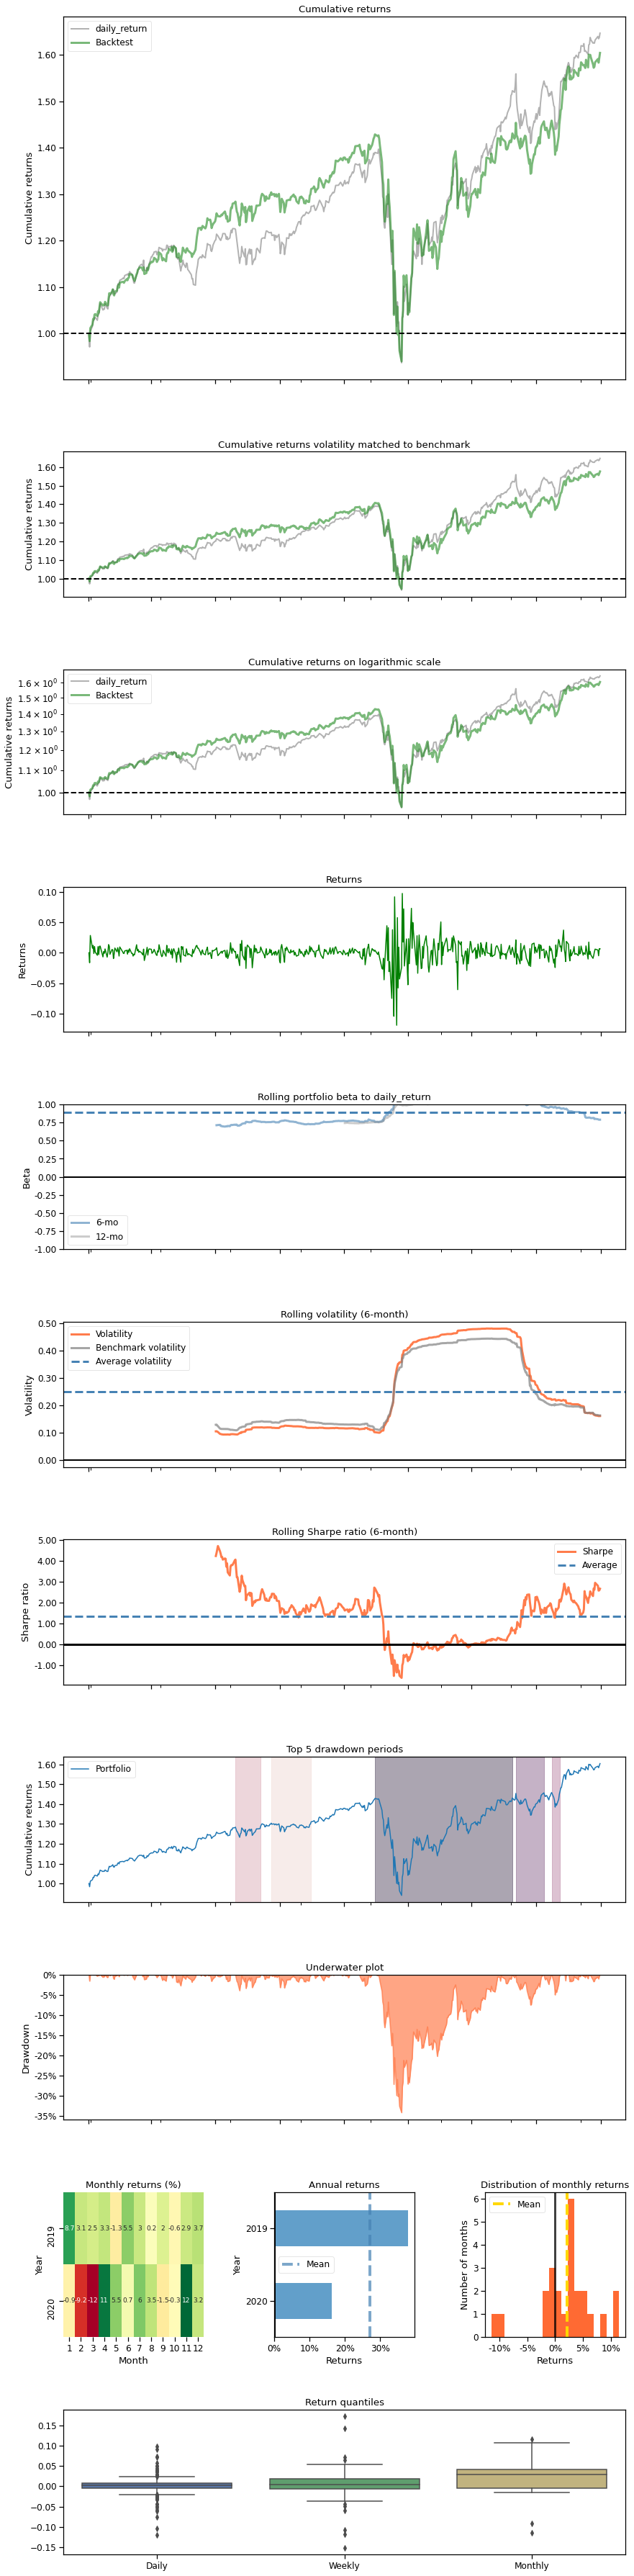

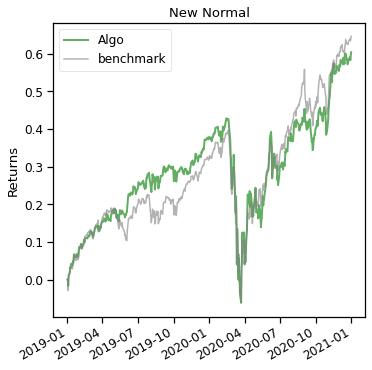

In [72]:
import pyfolio
%matplotlib inline

baseline_df = get_baseline(
        ticker='SUSA', start='2019-01-01', end='2021-01-01'
    )

baseline_returns = get_daily_return(baseline_df, value_col_name="close")

with pyfolio.plotting.plotting_context(font_scale=1.1):
        pyfolio.create_full_tear_sheet(returns = DRL_strat,
                                       benchmark_rets=baseline_returns, set_context=False)

In [38]:
df_daily_return, df_actions = DRLAgent.DRL_prediction(model=trained_ppo,
                        environment = e_trade_gym)

begin_total_asset:100000
end_total_asset:168242.03636093225
Sharpe:  1.0980528125956004
hit end!


In [39]:
df_daily_return

,date,daily_return
0,2019-01-02,0.000000
1,2019-01-03,-0.013886
2,2019-01-04,0.036621
3,2019-01-07,0.014101
4,2019-01-08,0.012594
...,...,...
500,2020-12-24,0.006436
501,2020-12-28,0.002336
502,2020-12-29,-0.004897
503,2020-12-30,0.007030


In [40]:
df_actions.head()

,AMD,AMT,BBY,BIIB,BKR,CAT,CB,DHR,DIS,EA,ECL,ED,ES,FISV,GWW,HAS,HBAN,K,KO,WELL
date,,,,,,,,,,,,,,,,,,,,
2019-01-02,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000
2019-01-03,0.040674,0.067840,0.041281,0.040674,0.040674,0.040674,0.040674,0.040674,0.040674,0.110562,0.040674,0.056083,0.040674,0.040674,0.040674,0.040674,0.040674,0.044241,0.040674,0.110562
2019-01-04,0.080913,0.037593,0.045020,0.037593,0.102187,0.037593,0.037593,0.037593,0.061886,0.058542,0.037593,0.083329,0.062435,0.037593,0.037593,0.037593,0.037593,0.037593,0.042516,0.049652
2019-01-07,0.038809,0.046206,0.105494,0.038809,0.058730,0.038809,0.045666,0.038809,0.038809,0.038809,0.038809,0.038809,0.038809,0.058270,0.038809,0.038809,0.105494,0.038809,0.052866,0.061565
2019-01-08,0.068032,0.033138,0.025027,0.068032,0.068032,0.068032,0.025027,0.068032,0.068032,0.036817,0.065643,0.068032,0.041856,0.057212,0.039080,0.029659,0.052231,0.068032,0.025027,0.025027


In [41]:
df_actions.to_csv('df_actions_ppo_20_1.csv')

In [42]:
DRL_strat = convert_daily_return_to_pyfolio_ts(df_daily_return)
perf_func = timeseries.perf_stats 
perf_stats_all = perf_func( returns=DRL_strat, 
                              factor_returns=DRL_strat, 
                                positions=None, transactions=None, turnover_denom="AGB")

In [43]:
print("==============DRL Strategy Stats===========")
perf_stats_all

==============DRL Strategy Stats===========


Annual return           0.296414
Cumulative returns      0.682420
Annual volatility       0.269684
Sharpe ratio            1.098053
Calmar ratio            0.911668
Stability               0.747801
Max drawdown           -0.325133
Omega ratio             1.267229
Sortino ratio           1.595611
Skew                   -0.146001
Kurtosis               13.040806
Tail ratio              1.002511
Daily value at risk    -0.032802
Alpha                   0.000000
Beta                    1.000000
dtype: float64

[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (506, 8)


Start date,2019-01-02
End date,2020-12-31
Total months,24
,Backtest
Annual return,29.641%
Cumulative returns,68.242%
Annual volatility,26.968%
Sharpe ratio,1.10
Calmar ratio,0.91
Stability,0.75
Max drawdown,-32.513%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,32.51,2020-02-14,2020-03-23,2020-06-05,81
1,8.91,2020-06-08,2020-06-26,2020-07-22,33
2,6.09,2020-09-02,2020-09-23,2020-10-08,27
3,5.62,2020-10-12,2020-10-28,2020-11-04,18
4,5.47,2019-07-30,2019-08-23,2019-10-21,60


Stress Events,mean,min,max
New Normal,0.12%,-10.49%,10.62%


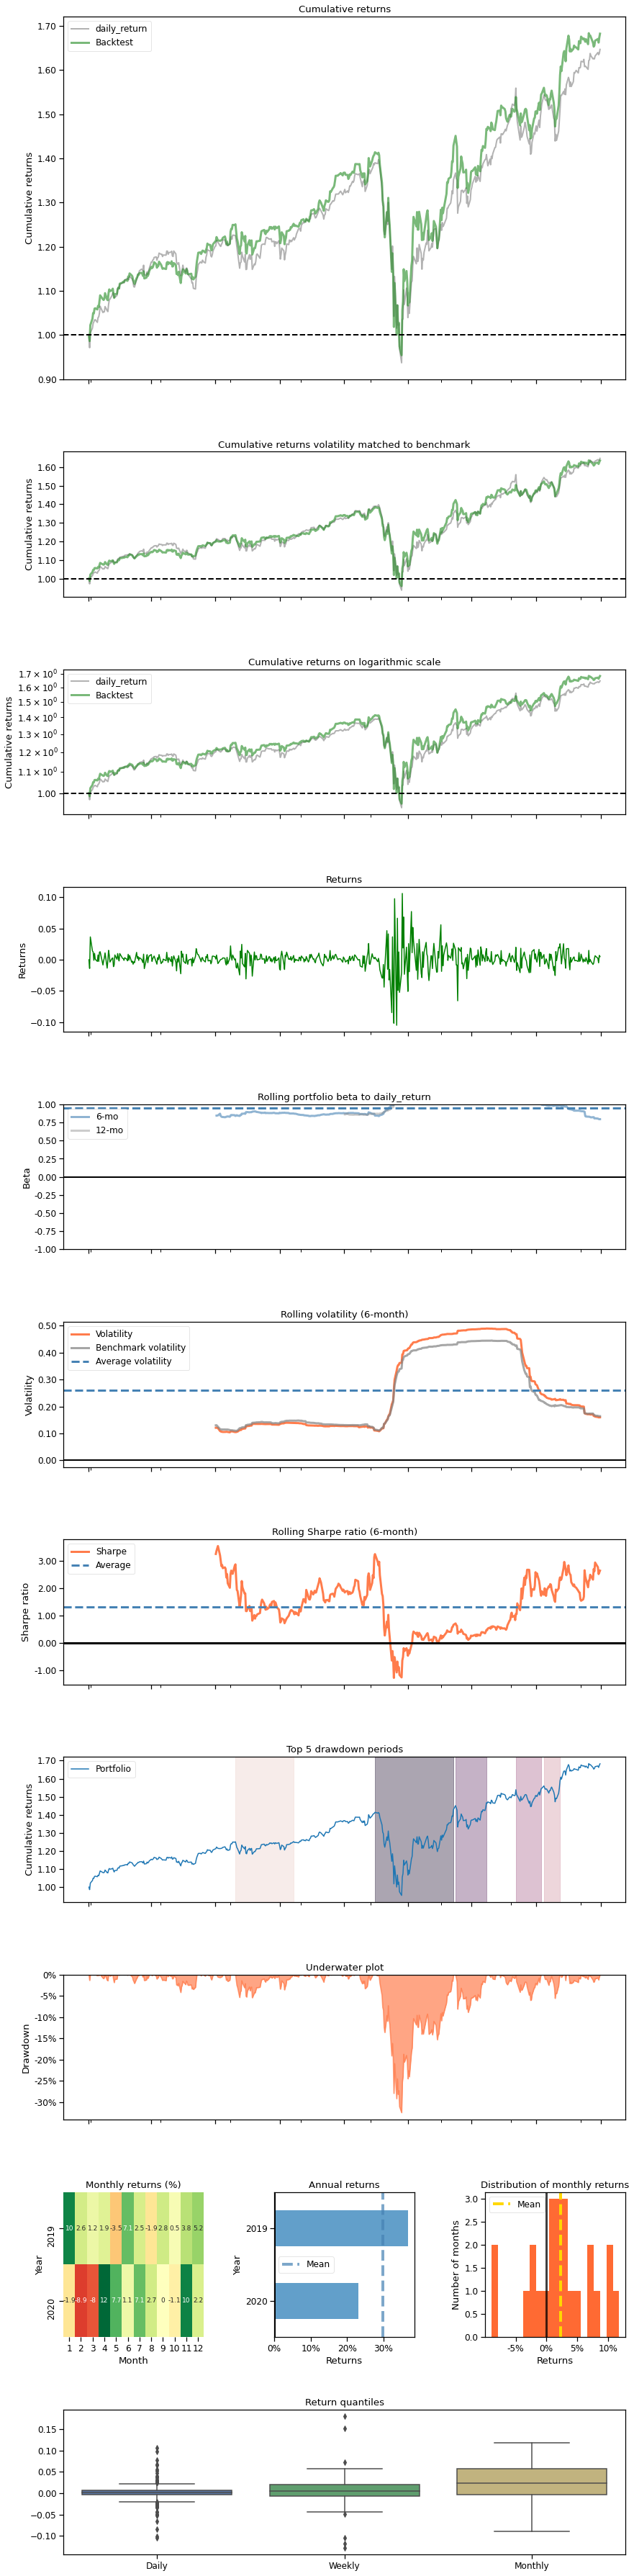

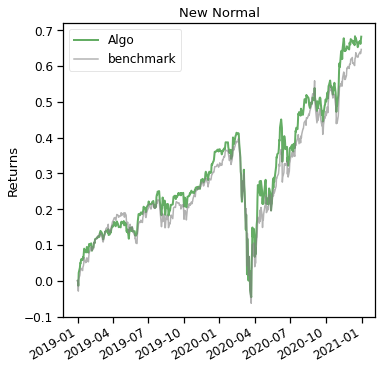

In [44]:
import pyfolio

%matplotlib inline

baseline_df = get_baseline(
        ticker='SUSA', start='2019-01-01', end='2021-01-01'
    )

baseline_returns = get_daily_return(baseline_df, value_col_name="close")

with pyfolio.plotting.plotting_context(font_scale=1.1):
        pyfolio.create_full_tear_sheet(returns = DRL_strat,
                                       benchmark_rets=baseline_returns, set_context=False)

In [59]:
df_daily_return, df_actions = DRLAgent.DRL_prediction(model=trained_sac,
                        environment = e_trade_gym)

begin_total_asset:100000
end_total_asset:162688.03493270604
Sharpe:  1.0348287632941497
hit end!


In [60]:
df_daily_return

,date,daily_return
0,2019-01-02,0.000000
1,2019-01-03,-0.017777
2,2019-01-04,0.033552
3,2019-01-07,0.014578
4,2019-01-08,0.013614
...,...,...
500,2020-12-24,0.005383
501,2020-12-28,0.001805
502,2020-12-29,-0.005538
503,2020-12-30,0.007363


In [61]:
df_actions

,AMD,AMT,BBY,BIIB,BKR,CAT,CB,DHR,DIS,EA,ECL,ED,ES,FISV,GWW,HAS,HBAN,K,KO,WELL
date,,,,,,,,,,,,,,,,,,,,
2019-01-02,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000
2019-01-03,0.064861,0.024963,0.060591,0.064645,0.065156,0.065264,0.024841,0.024614,0.065547,0.024195,0.065478,0.063175,0.053719,0.024251,0.062461,0.063746,0.031117,0.061933,0.024287,0.065156
2019-01-04,0.065649,0.025581,0.065348,0.065016,0.056660,0.065203,0.024747,0.024872,0.055245,0.024704,0.063615,0.064938,0.059716,0.024643,0.065930,0.065274,0.025080,0.066167,0.026949,0.064662
2019-01-07,0.066238,0.024559,0.062955,0.066344,0.062370,0.048628,0.025076,0.026539,0.063294,0.024881,0.066034,0.064177,0.061597,0.024582,0.066017,0.063593,0.025755,0.065288,0.025694,0.066378
2019-01-08,0.065126,0.025802,0.063317,0.062056,0.063047,0.063263,0.024377,0.024273,0.063416,0.025014,0.063486,0.065237,0.062485,0.024271,0.062843,0.065023,0.028647,0.058644,0.027245,0.062429
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-24,0.065495,0.025879,0.059318,0.067892,0.034497,0.065523,0.031809,0.025399,0.068094,0.026299,0.066701,0.062817,0.066757,0.025748,0.058082,0.065745,0.029840,0.062425,0.025268,0.066413
2020-12-28,0.063432,0.026603,0.058310,0.058107,0.065249,0.065824,0.025799,0.025182,0.063169,0.025040,0.063160,0.065888,0.061296,0.025429,0.065242,0.065135,0.036653,0.054184,0.026039,0.060259
2020-12-29,0.068330,0.026536,0.068495,0.066466,0.048102,0.066981,0.028933,0.026049,0.066886,0.025260,0.058471,0.046645,0.062314,0.026037,0.062834,0.066313,0.025561,0.066018,0.025353,0.068417


In [62]:
df_actions.to_csv('df_actions_sac_20_1.csv')

In [63]:
DRL_strat = convert_daily_return_to_pyfolio_ts(df_daily_return)
perf_func = timeseries.perf_stats 
perf_stats_all = perf_func( returns=DRL_strat, 
                              factor_returns=DRL_strat, 
                                positions=None, transactions=None, turnover_denom="AGB")

In [64]:
print("==============DRL Strategy Stats===========")
perf_stats_all

==============DRL Strategy Stats===========


Annual return           0.274878
Cumulative returns      0.626880
Annual volatility       0.270104
Sharpe ratio            1.034829
Calmar ratio            0.770177
Stability               0.597060
Max drawdown           -0.356902
Omega ratio             1.247067
Sortino ratio           1.480599
Skew                   -0.222793
Kurtosis               13.917898
Tail ratio              0.972732
Daily value at risk    -0.032921
Alpha                   0.000000
Beta                    1.000000
dtype: float64

[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (506, 8)


Start date,2019-01-02
End date,2020-12-31
Total months,24
,Backtest
Annual return,27.488%
Cumulative returns,62.688%
Annual volatility,27.01%
Sharpe ratio,1.03
Calmar ratio,0.77
Stability,0.60
Max drawdown,-35.69%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,35.69,2020-02-19,2020-03-23,2020-08-12,126
1,7.87,2020-09-02,2020-09-23,2020-10-08,27
2,5.93,2020-10-12,2020-10-28,2020-11-04,18
3,5.34,2019-07-30,2019-08-23,2019-09-17,36
4,4.09,2020-01-17,2020-01-31,2020-02-13,20


Stress Events,mean,min,max
New Normal,0.11%,-10.68%,11.62%


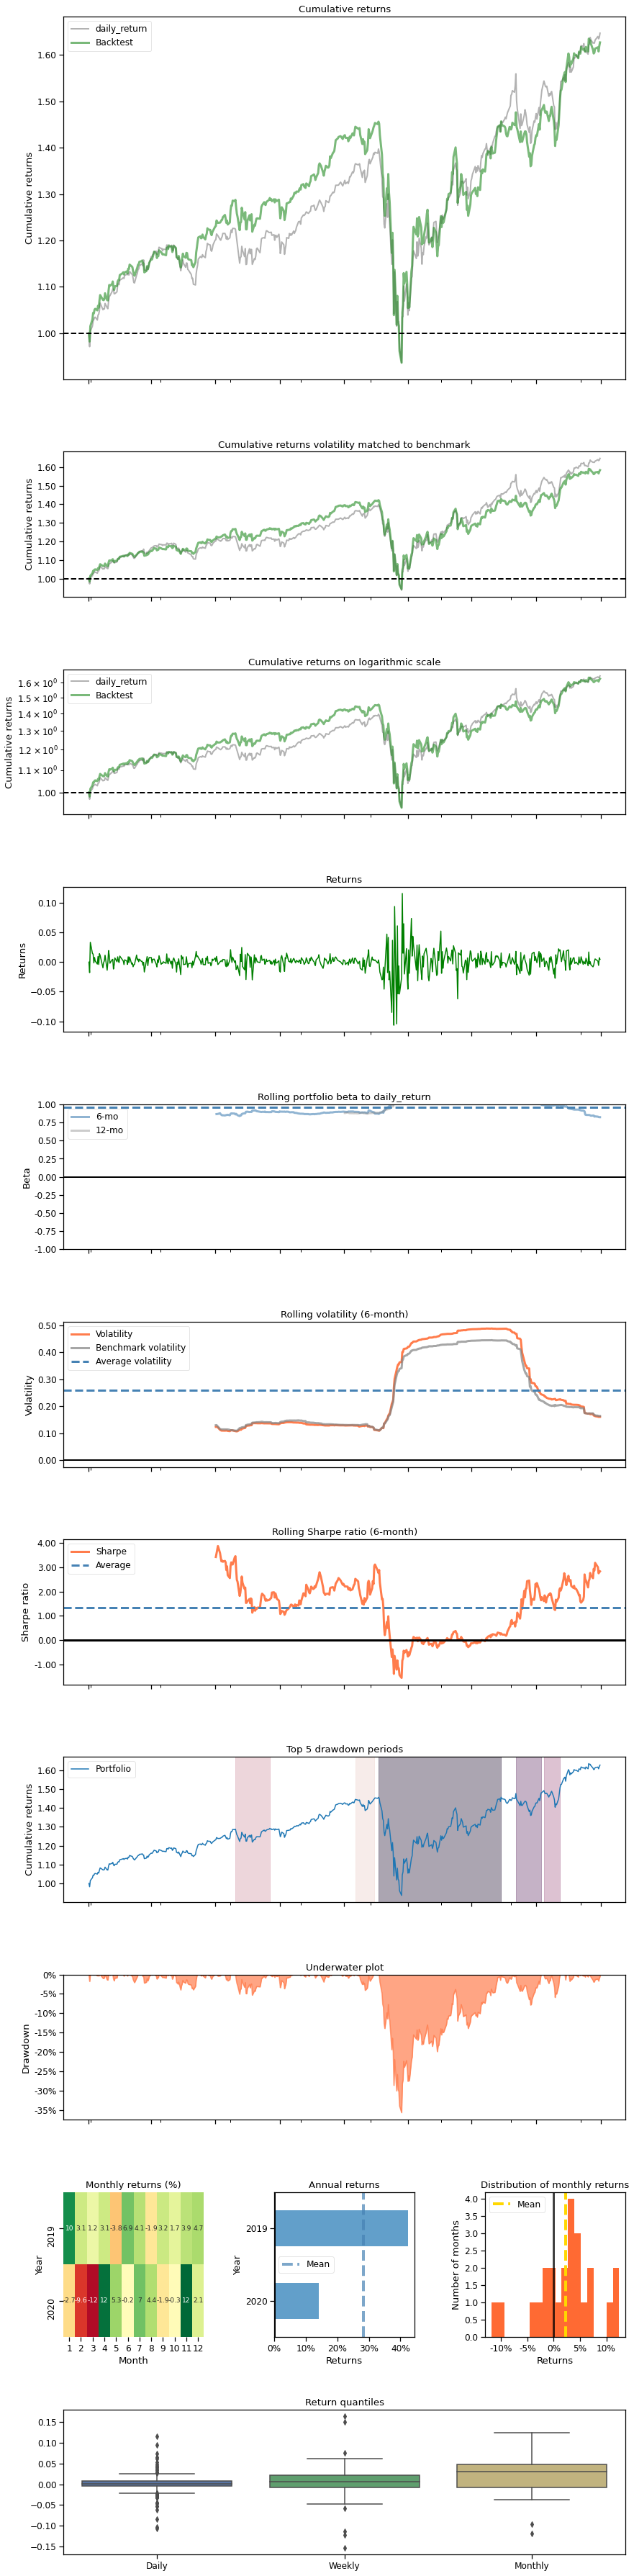

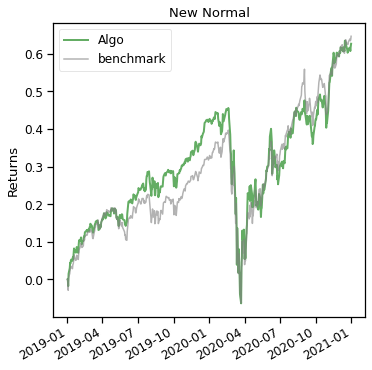

In [65]:
%matplotlib inline

baseline_df = get_baseline(
        ticker='SUSA', start='2019-01-01', end='2021-01-01'
    )

baseline_returns = get_daily_return(baseline_df, value_col_name="close")

with pyfolio.plotting.plotting_context(font_scale=1.1):
        pyfolio.create_full_tear_sheet(returns = DRL_strat,
                                       benchmark_rets=baseline_returns, set_context=False)